In [12]:
import sys
import os
import pandas as pd

from bokeh.palettes import Category10


from file_cache.utils.util_pandas import *
from file_cache.cache import file_cache

import matplotlib.pyplot as plt

#Adjust the working folder
file_folder = globals()['_dh'][0]
wk_dir = os.path.dirname(file_folder)
os.chdir(wk_dir)
from core.feature import *
from core.train import *
logging.getLogger().setLevel(logging.DEBUG)



In [24]:
blockid = 16487

cur_block = get_blocks().iloc[blockid]
logger.debug(f'cur_block:\n{cur_block}')
col_name = cur_block['col']
wtid = cur_block['wtid']
missing_length = cur_block['length']

cur_windows = round(missing_length * 0.7)

train = get_train_ex(wtid)

begin, end = cur_block.begin, cur_block.end
# Get the data without missing
block = train.iloc[max(0,begin - cur_windows):end + cur_windows + 1][['time_sn', col_name]]

#block = block.reset_index(drop=True)

logger.debug(f'wtid:{wtid}, col:{col_name}, len:{len(block)}, std:{block[col_name].std():2.2f}, blockid:{blockid}')
train_feature = block.dropna(how='any')
val_feature = block.loc[pd.isna(block[col_name])]

logger.debug(f'original: {train_feature.shape}, {val_feature.shape}')

time_gap = max(30, val_feature.time_sn.max() - val_feature.time_sn.min())
time_begin = val_feature.time_sn.min() - 5 * time_gap
time_end = val_feature.time_sn.max() + 5 * time_gap
# Make the train closed to validate
train_feature = train_feature[(train_feature.time_sn >= time_begin) & (train_feature.time_sn <= time_end)]

logger.debug(f'new(filter by time): {train_feature.shape}, {val_feature.shape}')

#return train_feature, val_feature



2019-01-24 21:24:15,772 <ipython-input-24-fc801117b259>[4] DEBUG cur_block:
begin            145
col           var001
distinct         NaN
end              455
kind         missing
max              NaN
min              NaN
wtid               6
length           311
data_type    float64
Name: 16487, dtype: object
2019-01-24 21:24:15,777 <ipython-input-24-fc801117b259>[19] DEBUG wtid:6, col:var001, len:674, std:2.23, blockid:16487
2019-01-24 21:24:15,780 <ipython-input-24-fc801117b259>[23] DEBUG original: (363, 2), (311, 2)
2019-01-24 21:24:15,785 <ipython-input-24-fc801117b259>[31] DEBUG new(filter by time): (363, 2), (311, 2)


In [21]:
train_feature.shape, val_feature.shape

((436, 2), (238, 2))

In [4]:
logging.getLogger().setLevel(logging.WARNING)
train_list = []
from tqdm import tqdm
for wtid in tqdm(range(1, 3)):
    train_ex =  predict_wtid(wtid)
    train_ex = train_ex.set_index(['ts', 'wtid'])
    train_list.append(train_ex)
submit = pd.concat(train_list)

100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


In [6]:
submit.shape

(720506, 69)

In [ ]:
logging.getLogger().setLevel(logging.INFO)
sub = predict_all()
sub.head()

2019-01-24 20:22:36,530 util_log.py[41] INFO predict_all begin with(0 paras) :[], []
2019-01-24 20:22:36,534 util_log.py[41] INFO get_sub_template begin with(0 paras) :[], []
2019-01-24 20:22:37,105 util_log.py[49] INFO get_sub_template cost    0.57 sec:(0 paras)([], []), return:DataFrame, end 
  0%|          | 0/33 [00:00<?, ?it/s]2019-01-24 20:23:00,092 util_log.py[41] INFO predict_wtid begin with(1 paras) :[1], []
2019-01-24 20:23:00,093 util_log.py[41] INFO get_train_block_all begin with(0 paras) :[], []
2019-01-24 20:23:00,182 util_log.py[49] INFO get_train_block_all cost    0.09 sec:(0 paras)([], []), return:DataFrame, end 
2019-01-24 20:23:00,184 util_log.py[41] INFO get_missing_block_all begin with(0 paras) :[], []
2019-01-24 20:23:00,220 util_log.py[49] INFO get_missing_block_all cost    0.04 sec:(0 paras)([], []), return:DataFrame, end 
/Users/lali2/Documents/workspace_py/df_jf/core/feature.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [20]:

from tqdm import tqdm
for i in tqdm(range(10, 20)):
    print(i)

100%|██████████| 10/10 [00:00<00:00, 14947.63it/s]

10
11
12
13
14
15
16
17
18
19


## Main

In [17]:
block_list = get_blocks()
for wtid in range(1, 2):
    train_ex = get_train_ex(wtid)
    for blockid, missing_block in block_list.loc[(block_list.wtid == wtid) & (block_list.kind == 'missing')].iterrows():
        col_name = missing_block.col
        train, sub = get_submit_feature_by_block_id(blockid)
        logger.info(f'blockid:{blockid}, train:{train.shape}')
        predict_fn = get_predict_fun(blockid, train)
        predict_res = predict_fn(sub.time_sn)
        sub[col_name] = predict_res
        logger.debug(f'predict_res:{predict_res.shape}, {type(predict_res)}')
        begin, end = missing_block.begin, missing_block.end

        logger.debug(f'train.loc[begin:end,col_name] = {train_ex.loc[begin:end,col_name].shape}, {begin}, {end}, {wtid}, {col_name}')
        train_ex.loc[begin:end,col_name] = predict_res
        
train_ex

2019-01-24 19:34:51,130 feature.py[281] DEBUG wtid:1, col:var001, len:524, std:0.48, blockid:1
2019-01-24 19:34:51,134 feature.py[285] DEBUG original: (306, 2), (218, 2)
2019-01-24 19:34:51,138 feature.py[293] DEBUG new(filter by time): (306, 2), (218, 2)
2019-01-24 19:34:51,141 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1, train:(306, 2)
2019-01-24 19:34:51,184 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(218,), <class 'numpy.ndarray'>
2019-01-24 19:34:51,187 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (218,), 9547, 9764, 1, var001
2019-01-24 19:34:51,636 feature.py[281] DEBUG wtid:1, col:var001, len:685, std:1.25, blockid:3
2019-01-24 19:34:51,641 feature.py[285] DEBUG original: (400, 2), (285, 2)
2019-01-24 19:34:51,646 feature.py[293] DEBUG new(filter by time): (400, 2), (285, 2)
2019-01-24 19:34:51,650 <ipython-input-17-a7d499fadc00>[7] INFO blockid:3, train:(400, 2)
2019-01-24 19:34:51,701 <ipython-input-17-a7d499fadc00>[11] DEBUG pred

2019-01-24 19:34:52,692 feature.py[281] DEBUG wtid:1, col:var001, len:507, std:2.15, blockid:29
2019-01-24 19:34:52,696 feature.py[285] DEBUG original: (296, 2), (211, 2)
2019-01-24 19:34:52,701 feature.py[293] DEBUG new(filter by time): (296, 2), (211, 2)
2019-01-24 19:34:52,704 <ipython-input-17-a7d499fadc00>[7] INFO blockid:29, train:(296, 2)
2019-01-24 19:34:52,751 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(211,), <class 'numpy.ndarray'>
2019-01-24 19:34:52,753 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (211,), 214560, 214770, 1, var001
2019-01-24 19:34:52,759 feature.py[281] DEBUG wtid:1, col:var001, len:988, std:2.68, blockid:31
2019-01-24 19:34:52,763 feature.py[285] DEBUG original: (576, 2), (412, 2)
2019-01-24 19:34:52,767 feature.py[293] DEBUG new(filter by time): (576, 2), (412, 2)
2019-01-24 19:34:52,768 <ipython-input-17-a7d499fadc00>[7] INFO blockid:31, train:(576, 2)
2019-01-24 19:34:52,812 <ipython-input-17-a7d499fadc00>[11] DE

2019-01-24 19:34:53,726 feature.py[281] DEBUG wtid:1, col:var002, len:713, std:0.12, blockid:58
2019-01-24 19:34:53,730 feature.py[285] DEBUG original: (416, 2), (297, 2)
2019-01-24 19:34:53,735 feature.py[293] DEBUG new(filter by time): (416, 2), (297, 2)
2019-01-24 19:34:53,737 <ipython-input-17-a7d499fadc00>[7] INFO blockid:58, train:(416, 2)
2019-01-24 19:34:53,785 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(297,), <class 'numpy.ndarray'>
2019-01-24 19:34:53,790 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (297,), 70657, 70953, 1, var002
2019-01-24 19:34:53,798 feature.py[281] DEBUG wtid:1, col:var002, len:3357, std:0.32, blockid:60
2019-01-24 19:34:53,803 feature.py[285] DEBUG original: (1958, 2), (1399, 2)
2019-01-24 19:34:53,809 feature.py[293] DEBUG new(filter by time): (1958, 2), (1399, 2)
2019-01-24 19:34:53,812 <ipython-input-17-a7d499fadc00>[7] INFO blockid:60, train:(1958, 2)
2019-01-24 19:34:53,864 <ipython-input-17-a7d499fadc00>[11

2019-01-24 19:34:54,790 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (421,), 265690, 266110, 1, var002
2019-01-24 19:34:54,797 feature.py[281] DEBUG wtid:1, col:var002, len:435, std:0.11, blockid:86
2019-01-24 19:34:54,801 feature.py[285] DEBUG original: (254, 2), (181, 2)
2019-01-24 19:34:54,805 feature.py[293] DEBUG new(filter by time): (254, 2), (181, 2)
2019-01-24 19:34:54,807 <ipython-input-17-a7d499fadc00>[7] INFO blockid:86, train:(254, 2)
2019-01-24 19:34:54,854 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(181,), <class 'numpy.ndarray'>
2019-01-24 19:34:54,857 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (181,), 285820, 286000, 1, var002
2019-01-24 19:34:54,864 feature.py[281] DEBUG wtid:1, col:var002, len:274, std:0.21, blockid:88
2019-01-24 19:34:54,868 feature.py[285] DEBUG original: (160, 2), (114, 2)
2019-01-24 19:34:54,876 feature.py[293] DEBUG new(filter by time): (160, 2), (114, 2)
2019-01-24 19:34:54,8

2019-01-24 19:34:55,858 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (36,), 119349, 119384, 1, var003
2019-01-24 19:34:55,865 feature.py[281] DEBUG wtid:1, col:var003, len:254, std:0.88, blockid:115
2019-01-24 19:34:55,869 feature.py[285] DEBUG original: (148, 2), (106, 2)
2019-01-24 19:34:55,874 feature.py[293] DEBUG new(filter by time): (148, 2), (106, 2)
2019-01-24 19:34:55,877 <ipython-input-17-a7d499fadc00>[7] INFO blockid:115, train:(148, 2)
2019-01-24 19:34:55,925 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(106,), <class 'numpy.ndarray'>
2019-01-24 19:34:55,927 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (106,), 134844, 134949, 1, var003
2019-01-24 19:34:55,935 feature.py[281] DEBUG wtid:1, col:var003, len:634, std:2.61, blockid:117
2019-01-24 19:34:55,939 feature.py[285] DEBUG original: (370, 2), (264, 2)
2019-01-24 19:34:55,945 feature.py[293] DEBUG new(filter by time): (370, 2), (264, 2)
2019-01-24 19:34:55

2019-01-24 19:34:56,897 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(349,), <class 'numpy.ndarray'>
2019-01-24 19:34:56,904 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (349,), 334602, 334950, 1, var003
2019-01-24 19:34:56,911 feature.py[281] DEBUG wtid:1, col:var003, len:3, std:0.00, blockid:143
2019-01-24 19:34:56,914 feature.py[285] DEBUG original: (2, 2), (1, 2)
2019-01-24 19:34:56,920 feature.py[293] DEBUG new(filter by time): (2, 2), (1, 2)
2019-01-24 19:34:56,922 <ipython-input-17-a7d499fadc00>[7] INFO blockid:143, train:(2, 2)
2019-01-24 19:34:56,970 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1,), <class 'numpy.ndarray'>
2019-01-24 19:34:56,977 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1,), 354983, 354983, 1, var003
2019-01-24 19:34:56,986 feature.py[281] DEBUG wtid:1, col:var003, len:48, std:0.14, blockid:145
2019-01-24 19:34:56,990 feature.py[285] DEBUG original: (28, 2), (20, 2)
2019-01-24 19

2019-01-24 19:34:57,890 <ipython-input-17-a7d499fadc00>[7] INFO blockid:170, train:(904, 2)
2019-01-24 19:34:57,942 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(646,), <class 'numpy.ndarray'>
2019-01-24 19:34:57,946 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (646,), 177479, 178124, 1, var004
2019-01-24 19:34:57,953 feature.py[281] DEBUG wtid:1, col:var004, len:755, std:161.03, blockid:172
2019-01-24 19:34:57,957 feature.py[285] DEBUG original: (440, 2), (315, 2)
2019-01-24 19:34:57,963 feature.py[293] DEBUG new(filter by time): (440, 2), (315, 2)
2019-01-24 19:34:57,967 <ipython-input-17-a7d499fadc00>[7] INFO blockid:172, train:(440, 2)
2019-01-24 19:34:58,016 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(315,), <class 'numpy.ndarray'>
2019-01-24 19:34:58,018 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (315,), 194890, 195204, 1, var004
2019-01-24 19:34:58,025 feature.py[281] DEBUG wtid:1, col:var004, len:66

2019-01-24 19:34:58,922 <ipython-input-17-a7d499fadc00>[7] INFO blockid:199, train:(400, 2)
2019-01-24 19:34:58,974 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(285,), <class 'numpy.ndarray'>
2019-01-24 19:34:58,978 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (285,), 27674, 27958, 1, var005
2019-01-24 19:34:58,984 feature.py[281] DEBUG wtid:1, col:var005, len:203, std:1.15, blockid:201
2019-01-24 19:34:58,988 feature.py[285] DEBUG original: (118, 2), (85, 2)
2019-01-24 19:34:58,992 feature.py[293] DEBUG new(filter by time): (118, 2), (85, 2)
2019-01-24 19:34:58,995 <ipython-input-17-a7d499fadc00>[7] INFO blockid:201, train:(118, 2)
2019-01-24 19:34:59,042 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(85,), <class 'numpy.ndarray'>
2019-01-24 19:34:59,047 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (85,), 35879, 35963, 1, var005
2019-01-24 19:34:59,053 feature.py[281] DEBUG wtid:1, col:var005, len:909, std:3.1

2019-01-24 19:35:00,020 feature.py[293] DEBUG new(filter by time): (576, 2), (412, 2)
2019-01-24 19:35:00,023 <ipython-input-17-a7d499fadc00>[7] INFO blockid:227, train:(576, 2)
2019-01-24 19:35:00,074 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(412,), <class 'numpy.ndarray'>
2019-01-24 19:35:00,078 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (412,), 229044, 229455, 1, var005
2019-01-24 19:35:00,085 feature.py[281] DEBUG wtid:1, col:var005, len:497, std:0.93, blockid:229
2019-01-24 19:35:00,088 feature.py[285] DEBUG original: (290, 2), (207, 2)
2019-01-24 19:35:00,093 feature.py[293] DEBUG new(filter by time): (290, 2), (207, 2)
2019-01-24 19:35:00,097 <ipython-input-17-a7d499fadc00>[7] INFO blockid:229, train:(290, 2)
2019-01-24 19:35:00,150 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(207,), <class 'numpy.ndarray'>
2019-01-24 19:35:00,155 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (207,), 240763, 240969

2019-01-24 19:35:01,070 feature.py[293] DEBUG new(filter by time): (1958, 2), (1399, 2)
2019-01-24 19:35:01,072 <ipython-input-17-a7d499fadc00>[7] INFO blockid:256, train:(1958, 2)
2019-01-24 19:35:01,123 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1399,), <class 'numpy.ndarray'>
2019-01-24 19:35:01,126 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1399,), 73292, 74690, 1, var006
2019-01-24 19:35:01,133 feature.py[281] DEBUG wtid:1, col:var006, len:3364, std:0.47, blockid:258
2019-01-24 19:35:01,138 feature.py[285] DEBUG original: (1962, 2), (1402, 2)
2019-01-24 19:35:01,146 feature.py[293] DEBUG new(filter by time): (1962, 2), (1402, 2)
2019-01-24 19:35:01,149 <ipython-input-17-a7d499fadc00>[7] INFO blockid:258, train:(1962, 2)
2019-01-24 19:35:01,199 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1402,), <class 'numpy.ndarray'>
2019-01-24 19:35:01,202 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1402,), 105

2019-01-24 19:35:02,096 feature.py[285] DEBUG original: (160, 2), (114, 2)
2019-01-24 19:35:02,103 feature.py[293] DEBUG new(filter by time): (160, 2), (114, 2)
2019-01-24 19:35:02,105 <ipython-input-17-a7d499fadc00>[7] INFO blockid:284, train:(160, 2)
2019-01-24 19:35:02,160 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(114,), <class 'numpy.ndarray'>
2019-01-24 19:35:02,164 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (114,), 300477, 300590, 1, var006
2019-01-24 19:35:02,172 feature.py[281] DEBUG wtid:1, col:var006, len:2558, std:0.47, blockid:286
2019-01-24 19:35:02,177 feature.py[285] DEBUG original: (1492, 2), (1066, 2)
2019-01-24 19:35:02,184 feature.py[293] DEBUG new(filter by time): (1492, 2), (1066, 2)
2019-01-24 19:35:02,186 <ipython-input-17-a7d499fadc00>[7] INFO blockid:286, train:(1492, 2)
2019-01-24 19:35:02,241 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1066,), <class 'numpy.ndarray'>
2019-01-24 19:35:02,244 <ipython-input

2019-01-24 19:35:03,213 feature.py[285] DEBUG original: (370, 2), (264, 2)
2019-01-24 19:35:03,221 feature.py[293] DEBUG new(filter by time): (370, 2), (264, 2)
2019-01-24 19:35:03,229 <ipython-input-17-a7d499fadc00>[7] INFO blockid:313, train:(370, 2)
2019-01-24 19:35:03,293 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(264,), <class 'numpy.ndarray'>
2019-01-24 19:35:03,297 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (264,), 146532, 146795, 1, var007
2019-01-24 19:35:03,306 feature.py[281] DEBUG wtid:1, col:var007, len:751, std:0.08, blockid:315
2019-01-24 19:35:03,313 feature.py[285] DEBUG original: (438, 2), (313, 2)
2019-01-24 19:35:03,322 feature.py[293] DEBUG new(filter by time): (438, 2), (313, 2)
2019-01-24 19:35:03,326 <ipython-input-17-a7d499fadc00>[7] INFO blockid:315, train:(438, 2)
2019-01-24 19:35:03,383 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(313,), <class 'numpy.ndarray'>
2019-01-24 19:35:03,387 <ipython-input-17-a7d

2019-01-24 19:35:04,392 feature.py[285] DEBUG original: (28, 2), (20, 2)
2019-01-24 19:35:04,398 feature.py[293] DEBUG new(filter by time): (28, 2), (20, 2)
2019-01-24 19:35:04,401 <ipython-input-17-a7d499fadc00>[7] INFO blockid:341, train:(28, 2)
2019-01-24 19:35:04,460 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(20,), <class 'numpy.ndarray'>
2019-01-24 19:35:04,465 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (20,), 356975, 356994, 1, var007
2019-01-24 19:35:04,473 feature.py[281] DEBUG wtid:1, col:var008, len:524, std:0.00, blockid:344
2019-01-24 19:35:04,478 feature.py[285] DEBUG original: (306, 2), (218, 2)
2019-01-24 19:35:04,487 feature.py[293] DEBUG new(filter by time): (306, 2), (218, 2)
2019-01-24 19:35:04,492 <ipython-input-17-a7d499fadc00>[7] INFO blockid:344, train:(306, 2)
2019-01-24 19:35:04,556 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(218,), <class 'numpy.ndarray'>
2019-01-24 19:35:04,562 <ipython-input-17-a7d499fadc

2019-01-24 19:35:05,584 feature.py[285] DEBUG original: (440, 2), (315, 2)
2019-01-24 19:35:05,589 feature.py[293] DEBUG new(filter by time): (440, 2), (315, 2)
2019-01-24 19:35:05,592 <ipython-input-17-a7d499fadc00>[7] INFO blockid:370, train:(440, 2)
2019-01-24 19:35:05,645 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(315,), <class 'numpy.ndarray'>
2019-01-24 19:35:05,647 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (315,), 194890, 195204, 1, var008
2019-01-24 19:35:05,655 feature.py[281] DEBUG wtid:1, col:var008, len:668, std:0.00, blockid:372
2019-01-24 19:35:05,660 feature.py[285] DEBUG original: (390, 2), (278, 2)
2019-01-24 19:35:05,666 feature.py[293] DEBUG new(filter by time): (390, 2), (278, 2)
2019-01-24 19:35:05,670 <ipython-input-17-a7d499fadc00>[7] INFO blockid:372, train:(390, 2)
2019-01-24 19:35:05,719 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(278,), <class 'numpy.ndarray'>
2019-01-24 19:35:05,723 <ipython-input-17-a7d

2019-01-24 19:35:06,636 feature.py[285] DEBUG original: (530, 2), (379, 2)
2019-01-24 19:35:06,641 feature.py[293] DEBUG new(filter by time): (530, 2), (379, 2)
2019-01-24 19:35:06,644 <ipython-input-17-a7d499fadc00>[7] INFO blockid:399, train:(530, 2)
2019-01-24 19:35:06,696 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(379,), <class 'numpy.ndarray'>
2019-01-24 19:35:06,699 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (379,), 47257, 47635, 1, var009
2019-01-24 19:35:06,707 feature.py[281] DEBUG wtid:1, col:var009, len:500, std:0.00, blockid:401
2019-01-24 19:35:06,711 feature.py[285] DEBUG original: (292, 2), (208, 2)
2019-01-24 19:35:06,717 feature.py[293] DEBUG new(filter by time): (292, 2), (208, 2)
2019-01-24 19:35:06,720 <ipython-input-17-a7d499fadc00>[7] INFO blockid:401, train:(292, 2)
2019-01-24 19:35:06,769 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(208,), <class 'numpy.ndarray'>
2019-01-24 19:35:06,773 <ipython-input-17-a7d49

2019-01-24 19:35:07,676 feature.py[281] DEBUG wtid:1, col:var009, len:1011, std:0.03, blockid:427
2019-01-24 19:35:07,680 feature.py[285] DEBUG original: (590, 2), (421, 2)
2019-01-24 19:35:07,684 feature.py[293] DEBUG new(filter by time): (590, 2), (421, 2)
2019-01-24 19:35:07,687 <ipython-input-17-a7d499fadc00>[7] INFO blockid:427, train:(590, 2)
2019-01-24 19:35:07,733 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(421,), <class 'numpy.ndarray'>
2019-01-24 19:35:07,738 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (421,), 265690, 266110, 1, var009
2019-01-24 19:35:07,748 feature.py[281] DEBUG wtid:1, col:var009, len:435, std:0.00, blockid:429
2019-01-24 19:35:07,753 feature.py[285] DEBUG original: (254, 2), (181, 2)
2019-01-24 19:35:07,759 feature.py[293] DEBUG new(filter by time): (254, 2), (181, 2)
2019-01-24 19:35:07,760 <ipython-input-17-a7d499fadc00>[7] INFO blockid:429, train:(254, 2)
2019-01-24 19:35:07,811 <ipython-input-17-a7d499fadc00>[1

2019-01-24 19:35:08,707 feature.py[281] DEBUG wtid:1, col:var010, len:3364, std:0.00, blockid:456
2019-01-24 19:35:08,711 feature.py[285] DEBUG original: (1962, 2), (1402, 2)
2019-01-24 19:35:08,717 feature.py[293] DEBUG new(filter by time): (1962, 2), (1402, 2)
2019-01-24 19:35:08,720 <ipython-input-17-a7d499fadc00>[7] INFO blockid:456, train:(1962, 2)
2019-01-24 19:35:08,769 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1402,), <class 'numpy.ndarray'>
2019-01-24 19:35:08,771 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1402,), 105777, 107178, 1, var010
2019-01-24 19:35:08,779 feature.py[281] DEBUG wtid:1, col:var010, len:254, std:0.00, blockid:458
2019-01-24 19:35:08,784 feature.py[285] DEBUG original: (148, 2), (106, 2)
2019-01-24 19:35:08,791 feature.py[293] DEBUG new(filter by time): (148, 2), (106, 2)
2019-01-24 19:35:08,795 <ipython-input-17-a7d499fadc00>[7] INFO blockid:458, train:(148, 2)
2019-01-24 19:35:08,845 <ipython-input-17-a7d499fa

2019-01-24 19:35:09,738 feature.py[281] DEBUG wtid:1, col:var010, len:837, std:0.01, blockid:484
2019-01-24 19:35:09,742 feature.py[285] DEBUG original: (488, 2), (349, 2)
2019-01-24 19:35:09,747 feature.py[293] DEBUG new(filter by time): (488, 2), (349, 2)
2019-01-24 19:35:09,750 <ipython-input-17-a7d499fadc00>[7] INFO blockid:484, train:(488, 2)
2019-01-24 19:35:09,798 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(349,), <class 'numpy.ndarray'>
2019-01-24 19:35:09,801 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (349,), 334602, 334950, 1, var010
2019-01-24 19:35:09,810 feature.py[281] DEBUG wtid:1, col:var010, len:374, std:0.01, blockid:486
2019-01-24 19:35:09,815 feature.py[285] DEBUG original: (218, 2), (156, 2)
2019-01-24 19:35:09,823 feature.py[293] DEBUG new(filter by time): (218, 2), (156, 2)
2019-01-24 19:35:09,828 <ipython-input-17-a7d499fadc00>[7] INFO blockid:486, train:(218, 2)
2019-01-24 19:35:09,885 <ipython-input-17-a7d499fadc00>[11

2019-01-24 19:35:10,777 feature.py[281] DEBUG wtid:1, col:var011, len:1550, std:0.08, blockid:513
2019-01-24 19:35:10,781 feature.py[285] DEBUG original: (904, 2), (646, 2)
2019-01-24 19:35:10,787 feature.py[293] DEBUG new(filter by time): (904, 2), (646, 2)
2019-01-24 19:35:10,791 <ipython-input-17-a7d499fadc00>[7] INFO blockid:513, train:(904, 2)
2019-01-24 19:35:10,842 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(646,), <class 'numpy.ndarray'>
2019-01-24 19:35:10,848 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (646,), 177479, 178124, 1, var011
2019-01-24 19:35:10,857 feature.py[281] DEBUG wtid:1, col:var011, len:755, std:0.10, blockid:515
2019-01-24 19:35:10,861 feature.py[285] DEBUG original: (440, 2), (315, 2)
2019-01-24 19:35:10,867 feature.py[293] DEBUG new(filter by time): (440, 2), (315, 2)
2019-01-24 19:35:10,870 <ipython-input-17-a7d499fadc00>[7] INFO blockid:515, train:(440, 2)
2019-01-24 19:35:10,919 <ipython-input-17-a7d499fadc00>[1

2019-01-24 19:35:11,824 feature.py[281] DEBUG wtid:1, col:var012, len:21, std:0.04, blockid:542
2019-01-24 19:35:11,830 feature.py[285] DEBUG original: (12, 2), (9, 2)
2019-01-24 19:35:11,835 feature.py[293] DEBUG new(filter by time): (12, 2), (9, 2)
2019-01-24 19:35:11,838 <ipython-input-17-a7d499fadc00>[7] INFO blockid:542, train:(12, 2)
2019-01-24 19:35:11,888 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(9,), <class 'numpy.ndarray'>
2019-01-24 19:35:11,890 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (9,), 16360, 16368, 1, var012
2019-01-24 19:35:11,900 feature.py[281] DEBUG wtid:1, col:var012, len:685, std:0.06, blockid:544
2019-01-24 19:35:11,905 feature.py[285] DEBUG original: (400, 2), (285, 2)
2019-01-24 19:35:11,911 feature.py[293] DEBUG new(filter by time): (400, 2), (285, 2)
2019-01-24 19:35:11,916 <ipython-input-17-a7d499fadc00>[7] INFO blockid:544, train:(400, 2)
2019-01-24 19:35:11,967 <ipython-input-17-a7d499fadc00>[11] DEBUG predic

2019-01-24 19:35:12,881 feature.py[281] DEBUG wtid:1, col:var012, len:988, std:0.24, blockid:570
2019-01-24 19:35:12,885 feature.py[285] DEBUG original: (576, 2), (412, 2)
2019-01-24 19:35:12,891 feature.py[293] DEBUG new(filter by time): (576, 2), (412, 2)
2019-01-24 19:35:12,895 <ipython-input-17-a7d499fadc00>[7] INFO blockid:570, train:(576, 2)
2019-01-24 19:35:12,948 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(412,), <class 'numpy.ndarray'>
2019-01-24 19:35:12,953 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (412,), 229044, 229455, 1, var012
2019-01-24 19:35:12,962 feature.py[281] DEBUG wtid:1, col:var012, len:292, std:0.06, blockid:572
2019-01-24 19:35:12,967 feature.py[285] DEBUG original: (170, 2), (122, 2)
2019-01-24 19:35:12,972 feature.py[293] DEBUG new(filter by time): (170, 2), (122, 2)
2019-01-24 19:35:12,976 <ipython-input-17-a7d499fadc00>[7] INFO blockid:572, train:(170, 2)
2019-01-24 19:35:13,028 <ipython-input-17-a7d499fadc00>[11

2019-01-24 19:35:13,947 feature.py[281] DEBUG wtid:1, col:var013, len:261, std:0.00, blockid:599
2019-01-24 19:35:13,952 feature.py[285] DEBUG original: (152, 2), (109, 2)
2019-01-24 19:35:13,957 feature.py[293] DEBUG new(filter by time): (152, 2), (109, 2)
2019-01-24 19:35:13,962 <ipython-input-17-a7d499fadc00>[7] INFO blockid:599, train:(152, 2)
2019-01-24 19:35:14,022 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(109,), <class 'numpy.ndarray'>
2019-01-24 19:35:14,027 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (109,), 83543, 83651, 1, var013
2019-01-24 19:35:14,035 feature.py[281] DEBUG wtid:1, col:var013, len:3364, std:0.00, blockid:601
2019-01-24 19:35:14,040 feature.py[285] DEBUG original: (1962, 2), (1402, 2)
2019-01-24 19:35:14,045 feature.py[293] DEBUG new(filter by time): (1962, 2), (1402, 2)
2019-01-24 19:35:14,050 <ipython-input-17-a7d499fadc00>[7] INFO blockid:601, train:(1962, 2)
2019-01-24 19:35:14,112 <ipython-input-17-a7d499fadc00

2019-01-24 19:35:15,125 feature.py[281] DEBUG wtid:1, col:var013, len:185, std:0.00, blockid:627
2019-01-24 19:35:15,132 feature.py[285] DEBUG original: (108, 2), (77, 2)
2019-01-24 19:35:15,137 feature.py[293] DEBUG new(filter by time): (108, 2), (77, 2)
2019-01-24 19:35:15,141 <ipython-input-17-a7d499fadc00>[7] INFO blockid:627, train:(108, 2)
2019-01-24 19:35:15,197 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(77,), <class 'numpy.ndarray'>
2019-01-24 19:35:15,202 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (77,), 300530, 300606, 1, var013
2019-01-24 19:35:15,210 feature.py[281] DEBUG wtid:1, col:var013, len:2558, std:0.00, blockid:629
2019-01-24 19:35:15,216 feature.py[285] DEBUG original: (1492, 2), (1066, 2)
2019-01-24 19:35:15,221 feature.py[293] DEBUG new(filter by time): (1492, 2), (1066, 2)
2019-01-24 19:35:15,225 <ipython-input-17-a7d499fadc00>[7] INFO blockid:629, train:(1492, 2)
2019-01-24 19:35:15,279 <ipython-input-17-a7d499fadc00>[

2019-01-24 19:35:16,254 feature.py[281] DEBUG wtid:1, col:var014, len:634, std:0.11, blockid:656
2019-01-24 19:35:16,257 feature.py[285] DEBUG original: (370, 2), (264, 2)
2019-01-24 19:35:16,264 feature.py[293] DEBUG new(filter by time): (370, 2), (264, 2)
2019-01-24 19:35:16,267 <ipython-input-17-a7d499fadc00>[7] INFO blockid:656, train:(370, 2)
2019-01-24 19:35:16,315 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(264,), <class 'numpy.ndarray'>
2019-01-24 19:35:16,318 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (264,), 146532, 146795, 1, var014
2019-01-24 19:35:16,324 feature.py[281] DEBUG wtid:1, col:var014, len:751, std:0.08, blockid:658
2019-01-24 19:35:16,329 feature.py[285] DEBUG original: (438, 2), (313, 2)
2019-01-24 19:35:16,336 feature.py[293] DEBUG new(filter by time): (438, 2), (313, 2)
2019-01-24 19:35:16,338 <ipython-input-17-a7d499fadc00>[7] INFO blockid:658, train:(438, 2)
2019-01-24 19:35:16,389 <ipython-input-17-a7d499fadc00>[11

2019-01-24 19:35:17,303 feature.py[281] DEBUG wtid:1, col:var014, len:48, std:0.00, blockid:684
2019-01-24 19:35:17,309 feature.py[285] DEBUG original: (28, 2), (20, 2)
2019-01-24 19:35:17,315 feature.py[293] DEBUG new(filter by time): (28, 2), (20, 2)
2019-01-24 19:35:17,318 <ipython-input-17-a7d499fadc00>[7] INFO blockid:684, train:(28, 2)
2019-01-24 19:35:17,365 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(20,), <class 'numpy.ndarray'>
2019-01-24 19:35:17,369 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (20,), 356975, 356994, 1, var014
2019-01-24 19:35:17,374 feature.py[281] DEBUG wtid:1, col:var015, len:511, std:15.81, blockid:687
2019-01-24 19:35:17,379 feature.py[285] DEBUG original: (298, 2), (213, 2)
2019-01-24 19:35:17,383 feature.py[293] DEBUG new(filter by time): (298, 2), (213, 2)
2019-01-24 19:35:17,386 <ipython-input-17-a7d499fadc00>[7] INFO blockid:687, train:(298, 2)
2019-01-24 19:35:17,433 <ipython-input-17-a7d499fadc00>[11] DEBUG

2019-01-24 19:35:18,310 feature.py[281] DEBUG wtid:1, col:var015, len:755, std:11.99, blockid:713
2019-01-24 19:35:18,313 feature.py[285] DEBUG original: (440, 2), (315, 2)
2019-01-24 19:35:18,318 feature.py[293] DEBUG new(filter by time): (440, 2), (315, 2)
2019-01-24 19:35:18,319 <ipython-input-17-a7d499fadc00>[7] INFO blockid:713, train:(440, 2)
2019-01-24 19:35:18,367 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(315,), <class 'numpy.ndarray'>
2019-01-24 19:35:18,372 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (315,), 194890, 195204, 1, var015
2019-01-24 19:35:18,384 feature.py[281] DEBUG wtid:1, col:var015, len:668, std:13.91, blockid:715
2019-01-24 19:35:18,390 feature.py[285] DEBUG original: (390, 2), (278, 2)
2019-01-24 19:35:18,395 feature.py[293] DEBUG new(filter by time): (390, 2), (278, 2)
2019-01-24 19:35:18,398 <ipython-input-17-a7d499fadc00>[7] INFO blockid:715, train:(390, 2)
2019-01-24 19:35:18,449 <ipython-input-17-a7d499fadc00>[

2019-01-24 19:35:19,318 feature.py[281] DEBUG wtid:1, col:var016, len:909, std:0.00, blockid:742
2019-01-24 19:35:19,322 feature.py[285] DEBUG original: (530, 2), (379, 2)
2019-01-24 19:35:19,326 feature.py[293] DEBUG new(filter by time): (530, 2), (379, 2)
2019-01-24 19:35:19,329 <ipython-input-17-a7d499fadc00>[7] INFO blockid:742, train:(530, 2)
2019-01-24 19:35:19,376 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(379,), <class 'numpy.ndarray'>
2019-01-24 19:35:19,382 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (379,), 47257, 47635, 1, var016
2019-01-24 19:35:19,392 feature.py[281] DEBUG wtid:1, col:var016, len:3357, std:0.00, blockid:744
2019-01-24 19:35:19,396 feature.py[285] DEBUG original: (1958, 2), (1399, 2)
2019-01-24 19:35:19,403 feature.py[293] DEBUG new(filter by time): (1958, 2), (1399, 2)
2019-01-24 19:35:19,406 <ipython-input-17-a7d499fadc00>[7] INFO blockid:744, train:(1958, 2)
2019-01-24 19:35:19,456 <ipython-input-17-a7d499fadc00

2019-01-24 19:35:20,321 feature.py[281] DEBUG wtid:1, col:var016, len:1011, std:0.00, blockid:770
2019-01-24 19:35:20,325 feature.py[285] DEBUG original: (590, 2), (421, 2)
2019-01-24 19:35:20,330 feature.py[293] DEBUG new(filter by time): (590, 2), (421, 2)
2019-01-24 19:35:20,334 <ipython-input-17-a7d499fadc00>[7] INFO blockid:770, train:(590, 2)
2019-01-24 19:35:20,383 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(421,), <class 'numpy.ndarray'>
2019-01-24 19:35:20,388 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (421,), 265690, 266110, 1, var016
2019-01-24 19:35:20,396 feature.py[281] DEBUG wtid:1, col:var016, len:435, std:0.00, blockid:772
2019-01-24 19:35:20,402 feature.py[285] DEBUG original: (254, 2), (181, 2)
2019-01-24 19:35:20,406 feature.py[293] DEBUG new(filter by time): (254, 2), (181, 2)
2019-01-24 19:35:20,412 <ipython-input-17-a7d499fadc00>[7] INFO blockid:772, train:(254, 2)
2019-01-24 19:35:20,465 <ipython-input-17-a7d499fadc00>[1

2019-01-24 19:35:21,392 feature.py[281] DEBUG wtid:1, col:var017, len:3364, std:0.01, blockid:799
2019-01-24 19:35:21,396 feature.py[285] DEBUG original: (1962, 2), (1402, 2)
2019-01-24 19:35:21,402 feature.py[293] DEBUG new(filter by time): (1962, 2), (1402, 2)
2019-01-24 19:35:21,404 <ipython-input-17-a7d499fadc00>[7] INFO blockid:799, train:(1962, 2)
2019-01-24 19:35:21,454 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1402,), <class 'numpy.ndarray'>
2019-01-24 19:35:21,460 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1402,), 105777, 107178, 1, var017
2019-01-24 19:35:21,469 feature.py[281] DEBUG wtid:1, col:var017, len:254, std:0.02, blockid:801
2019-01-24 19:35:21,473 feature.py[285] DEBUG original: (148, 2), (106, 2)
2019-01-24 19:35:21,480 feature.py[293] DEBUG new(filter by time): (148, 2), (106, 2)
2019-01-24 19:35:21,483 <ipython-input-17-a7d499fadc00>[7] INFO blockid:801, train:(148, 2)
2019-01-24 19:35:21,530 <ipython-input-17-a7d499fa

2019-01-24 19:35:22,443 feature.py[281] DEBUG wtid:1, col:var017, len:837, std:0.01, blockid:827
2019-01-24 19:35:22,447 feature.py[285] DEBUG original: (488, 2), (349, 2)
2019-01-24 19:35:22,452 feature.py[293] DEBUG new(filter by time): (488, 2), (349, 2)
2019-01-24 19:35:22,454 <ipython-input-17-a7d499fadc00>[7] INFO blockid:827, train:(488, 2)
2019-01-24 19:35:22,500 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(349,), <class 'numpy.ndarray'>
2019-01-24 19:35:22,505 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (349,), 334602, 334950, 1, var017
2019-01-24 19:35:22,511 feature.py[281] DEBUG wtid:1, col:var017, len:374, std:0.01, blockid:829
2019-01-24 19:35:22,515 feature.py[285] DEBUG original: (218, 2), (156, 2)
2019-01-24 19:35:22,522 feature.py[293] DEBUG new(filter by time): (218, 2), (156, 2)
2019-01-24 19:35:22,525 <ipython-input-17-a7d499fadc00>[7] INFO blockid:829, train:(218, 2)
2019-01-24 19:35:22,575 <ipython-input-17-a7d499fadc00>[11

2019-01-24 19:35:23,496 feature.py[281] DEBUG wtid:1, col:var018, len:1550, std:0.10, blockid:856
2019-01-24 19:35:23,500 feature.py[285] DEBUG original: (904, 2), (646, 2)
2019-01-24 19:35:23,505 feature.py[293] DEBUG new(filter by time): (904, 2), (646, 2)
2019-01-24 19:35:23,507 <ipython-input-17-a7d499fadc00>[7] INFO blockid:856, train:(904, 2)
2019-01-24 19:35:23,556 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(646,), <class 'numpy.ndarray'>
2019-01-24 19:35:23,560 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (646,), 177479, 178124, 1, var018
2019-01-24 19:35:23,568 feature.py[281] DEBUG wtid:1, col:var018, len:755, std:0.07, blockid:858
2019-01-24 19:35:23,572 feature.py[285] DEBUG original: (440, 2), (315, 2)
2019-01-24 19:35:23,578 feature.py[293] DEBUG new(filter by time): (440, 2), (315, 2)
2019-01-24 19:35:23,581 <ipython-input-17-a7d499fadc00>[7] INFO blockid:858, train:(440, 2)
2019-01-24 19:35:23,633 <ipython-input-17-a7d499fadc00>[1

2019-01-24 19:35:24,551 feature.py[281] DEBUG wtid:1, col:var019, len:685, std:0.00, blockid:885
2019-01-24 19:35:24,554 feature.py[285] DEBUG original: (400, 2), (285, 2)
2019-01-24 19:35:24,559 feature.py[293] DEBUG new(filter by time): (400, 2), (285, 2)
2019-01-24 19:35:24,562 <ipython-input-17-a7d499fadc00>[7] INFO blockid:885, train:(400, 2)
2019-01-24 19:35:24,610 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(285,), <class 'numpy.ndarray'>
2019-01-24 19:35:24,614 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (285,), 27674, 27958, 1, var019
2019-01-24 19:35:24,622 feature.py[281] DEBUG wtid:1, col:var019, len:404, std:0.00, blockid:887
2019-01-24 19:35:24,626 feature.py[285] DEBUG original: (236, 2), (168, 2)
2019-01-24 19:35:24,632 feature.py[293] DEBUG new(filter by time): (236, 2), (168, 2)
2019-01-24 19:35:24,635 <ipython-input-17-a7d499fadc00>[7] INFO blockid:887, train:(236, 2)
2019-01-24 19:35:24,683 <ipython-input-17-a7d499fadc00>[11] 

2019-01-24 19:35:25,608 feature.py[281] DEBUG wtid:1, col:var019, len:988, std:0.03, blockid:913
2019-01-24 19:35:25,612 feature.py[285] DEBUG original: (576, 2), (412, 2)
2019-01-24 19:35:25,618 feature.py[293] DEBUG new(filter by time): (576, 2), (412, 2)
2019-01-24 19:35:25,621 <ipython-input-17-a7d499fadc00>[7] INFO blockid:913, train:(576, 2)
2019-01-24 19:35:25,672 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(412,), <class 'numpy.ndarray'>
2019-01-24 19:35:25,677 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (412,), 229044, 229455, 1, var019
2019-01-24 19:35:25,687 feature.py[281] DEBUG wtid:1, col:var019, len:552, std:0.00, blockid:915
2019-01-24 19:35:25,692 feature.py[285] DEBUG original: (322, 2), (230, 2)
2019-01-24 19:35:25,697 feature.py[293] DEBUG new(filter by time): (322, 2), (230, 2)
2019-01-24 19:35:25,701 <ipython-input-17-a7d499fadc00>[7] INFO blockid:915, train:(322, 2)
2019-01-24 19:35:25,751 <ipython-input-17-a7d499fadc00>[11

2019-01-24 19:35:26,671 feature.py[281] DEBUG wtid:1, col:var020, len:261, std:0.00, blockid:942
2019-01-24 19:35:26,674 feature.py[285] DEBUG original: (152, 2), (109, 2)
2019-01-24 19:35:26,680 feature.py[293] DEBUG new(filter by time): (152, 2), (109, 2)
2019-01-24 19:35:26,683 <ipython-input-17-a7d499fadc00>[7] INFO blockid:942, train:(152, 2)
2019-01-24 19:35:26,734 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(109,), <class 'numpy.ndarray'>
2019-01-24 19:35:26,737 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (109,), 83543, 83651, 1, var020
2019-01-24 19:35:26,744 feature.py[281] DEBUG wtid:1, col:var020, len:3364, std:0.00, blockid:944
2019-01-24 19:35:26,750 feature.py[285] DEBUG original: (1962, 2), (1402, 2)
2019-01-24 19:35:26,757 feature.py[293] DEBUG new(filter by time): (1962, 2), (1402, 2)
2019-01-24 19:35:26,760 <ipython-input-17-a7d499fadc00>[7] INFO blockid:944, train:(1962, 2)
2019-01-24 19:35:26,812 <ipython-input-17-a7d499fadc00

2019-01-24 19:35:27,739 feature.py[281] DEBUG wtid:1, col:var020, len:185, std:0.00, blockid:970
2019-01-24 19:35:27,743 feature.py[285] DEBUG original: (108, 2), (77, 2)
2019-01-24 19:35:27,748 feature.py[293] DEBUG new(filter by time): (108, 2), (77, 2)
2019-01-24 19:35:27,751 <ipython-input-17-a7d499fadc00>[7] INFO blockid:970, train:(108, 2)
2019-01-24 19:35:27,799 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(77,), <class 'numpy.ndarray'>
2019-01-24 19:35:27,803 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (77,), 300530, 300606, 1, var020
2019-01-24 19:35:27,811 feature.py[281] DEBUG wtid:1, col:var020, len:2558, std:0.00, blockid:972
2019-01-24 19:35:27,816 feature.py[285] DEBUG original: (1492, 2), (1066, 2)
2019-01-24 19:35:27,822 feature.py[293] DEBUG new(filter by time): (1492, 2), (1066, 2)
2019-01-24 19:35:27,827 <ipython-input-17-a7d499fadc00>[7] INFO blockid:972, train:(1492, 2)
2019-01-24 19:35:27,876 <ipython-input-17-a7d499fadc00>[

2019-01-24 19:35:28,789 feature.py[281] DEBUG wtid:1, col:var021, len:634, std:0.64, blockid:999
2019-01-24 19:35:28,794 feature.py[285] DEBUG original: (370, 2), (264, 2)
2019-01-24 19:35:28,800 feature.py[293] DEBUG new(filter by time): (370, 2), (264, 2)
2019-01-24 19:35:28,802 <ipython-input-17-a7d499fadc00>[7] INFO blockid:999, train:(370, 2)
2019-01-24 19:35:28,854 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(264,), <class 'numpy.ndarray'>
2019-01-24 19:35:28,859 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (264,), 146532, 146795, 1, var021
2019-01-24 19:35:28,867 feature.py[281] DEBUG wtid:1, col:var021, len:751, std:0.14, blockid:1001
2019-01-24 19:35:28,872 feature.py[285] DEBUG original: (438, 2), (313, 2)
2019-01-24 19:35:28,880 feature.py[293] DEBUG new(filter by time): (438, 2), (313, 2)
2019-01-24 19:35:28,884 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1001, train:(438, 2)
2019-01-24 19:35:28,936 <ipython-input-17-a7d499fadc00>[

2019-01-24 19:35:29,829 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1,), 354983, 354983, 1, var021
2019-01-24 19:35:29,838 feature.py[281] DEBUG wtid:1, col:var021, len:48, std:0.04, blockid:1027
2019-01-24 19:35:29,844 feature.py[285] DEBUG original: (28, 2), (20, 2)
2019-01-24 19:35:29,849 feature.py[293] DEBUG new(filter by time): (28, 2), (20, 2)
2019-01-24 19:35:29,853 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1027, train:(28, 2)
2019-01-24 19:35:29,901 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(20,), <class 'numpy.ndarray'>
2019-01-24 19:35:29,903 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (20,), 356975, 356994, 1, var021
2019-01-24 19:35:29,912 feature.py[281] DEBUG wtid:1, col:var022, len:524, std:0.12, blockid:1030
2019-01-24 19:35:29,918 feature.py[285] DEBUG original: (306, 2), (218, 2)
2019-01-24 19:35:29,923 feature.py[293] DEBUG new(filter by time): (306, 2), (218, 2)
2019-01-24 19:35:29,927 <

2019-01-24 19:35:30,829 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (315,), 194890, 195204, 1, var022
2019-01-24 19:35:30,836 feature.py[281] DEBUG wtid:1, col:var022, len:668, std:0.17, blockid:1056
2019-01-24 19:35:30,840 feature.py[285] DEBUG original: (390, 2), (278, 2)
2019-01-24 19:35:30,846 feature.py[293] DEBUG new(filter by time): (390, 2), (278, 2)
2019-01-24 19:35:30,848 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1056, train:(390, 2)
2019-01-24 19:35:30,900 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(278,), <class 'numpy.ndarray'>
2019-01-24 19:35:30,903 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (278,), 210531, 210808, 1, var022
2019-01-24 19:35:30,911 feature.py[281] DEBUG wtid:1, col:var022, len:953, std:0.14, blockid:1058
2019-01-24 19:35:30,918 feature.py[285] DEBUG original: (556, 2), (397, 2)
2019-01-24 19:35:30,929 feature.py[293] DEBUG new(filter by time): (556, 2), (397, 2)
2019-01-24 19:3

2019-01-24 19:35:31,881 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (168,), 27992, 28159, 1, var023
2019-01-24 19:35:31,889 feature.py[281] DEBUG wtid:1, col:var023, len:909, std:0.01, blockid:1085
2019-01-24 19:35:31,894 feature.py[285] DEBUG original: (530, 2), (379, 2)
2019-01-24 19:35:31,898 feature.py[293] DEBUG new(filter by time): (530, 2), (379, 2)
2019-01-24 19:35:31,901 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1085, train:(530, 2)
2019-01-24 19:35:31,949 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(379,), <class 'numpy.ndarray'>
2019-01-24 19:35:31,954 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (379,), 47257, 47635, 1, var023
2019-01-24 19:35:31,961 feature.py[281] DEBUG wtid:1, col:var023, len:500, std:0.01, blockid:1087
2019-01-24 19:35:31,965 feature.py[285] DEBUG original: (292, 2), (208, 2)
2019-01-24 19:35:31,971 feature.py[293] DEBUG new(filter by time): (292, 2), (208, 2)
2019-01-24 19:35:31

2019-01-24 19:35:32,910 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(230,), <class 'numpy.ndarray'>
2019-01-24 19:35:32,912 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (230,), 238784, 239013, 1, var023
2019-01-24 19:35:32,919 feature.py[281] DEBUG wtid:1, col:var023, len:1011, std:0.01, blockid:1113
2019-01-24 19:35:32,922 feature.py[285] DEBUG original: (590, 2), (421, 2)
2019-01-24 19:35:32,929 feature.py[293] DEBUG new(filter by time): (590, 2), (421, 2)
2019-01-24 19:35:32,933 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1113, train:(590, 2)
2019-01-24 19:35:32,983 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(421,), <class 'numpy.ndarray'>
2019-01-24 19:35:32,986 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (421,), 265690, 266110, 1, var023
2019-01-24 19:35:32,993 feature.py[281] DEBUG wtid:1, col:var023, len:435, std:0.01, blockid:1115
2019-01-24 19:35:32,998 feature.py[285] DEBUG original: (254, 2),

2019-01-24 19:35:33,908 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1140, train:(1962, 2)
2019-01-24 19:35:33,956 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1402,), <class 'numpy.ndarray'>
2019-01-24 19:35:33,960 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1402,), 105777, 107178, 1, var024
2019-01-24 19:35:33,967 feature.py[281] DEBUG wtid:1, col:var024, len:86, std:0.40, blockid:1142
2019-01-24 19:35:33,972 feature.py[285] DEBUG original: (50, 2), (36, 2)
2019-01-24 19:35:33,978 feature.py[293] DEBUG new(filter by time): (50, 2), (36, 2)
2019-01-24 19:35:33,983 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1142, train:(50, 2)
2019-01-24 19:35:34,038 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(36,), <class 'numpy.ndarray'>
2019-01-24 19:35:34,040 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (36,), 119349, 119384, 1, var024
2019-01-24 19:35:34,049 feature.py[281] DEBUG wtid:1, col:var024, len:254, s

2019-01-24 19:35:34,981 feature.py[293] DEBUG new(filter by time): (1492, 2), (1066, 2)
2019-01-24 19:35:34,983 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1168, train:(1492, 2)
2019-01-24 19:35:35,030 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1066,), <class 'numpy.ndarray'>
2019-01-24 19:35:35,034 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1066,), 302843, 303908, 1, var024
2019-01-24 19:35:35,041 feature.py[281] DEBUG wtid:1, col:var024, len:837, std:2.06, blockid:1170
2019-01-24 19:35:35,046 feature.py[285] DEBUG original: (488, 2), (349, 2)
2019-01-24 19:35:35,051 feature.py[293] DEBUG new(filter by time): (488, 2), (349, 2)
2019-01-24 19:35:35,053 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1170, train:(488, 2)
2019-01-24 19:35:35,102 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(349,), <class 'numpy.ndarray'>
2019-01-24 19:35:35,106 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (349,), 334602

2019-01-24 19:35:35,984 feature.py[285] DEBUG original: (468, 2), (335, 2)
2019-01-24 19:35:35,988 feature.py[293] DEBUG new(filter by time): (468, 2), (335, 2)
2019-01-24 19:35:35,990 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1197, train:(468, 2)
2019-01-24 19:35:36,040 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(335,), <class 'numpy.ndarray'>
2019-01-24 19:35:36,043 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (335,), 151667, 152001, 1, var025
2019-01-24 19:35:36,051 feature.py[281] DEBUG wtid:1, col:var025, len:1550, std:0.00, blockid:1199
2019-01-24 19:35:36,056 feature.py[285] DEBUG original: (904, 2), (646, 2)
2019-01-24 19:35:36,063 feature.py[293] DEBUG new(filter by time): (904, 2), (646, 2)
2019-01-24 19:35:36,067 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1199, train:(904, 2)
2019-01-24 19:35:36,116 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(646,), <class 'numpy.ndarray'>
2019-01-24 19:35:36,119 <ipython-input-17

2019-01-24 19:35:36,989 feature.py[281] DEBUG wtid:1, col:var026, len:524, std:0.00, blockid:1226
2019-01-24 19:35:36,993 feature.py[285] DEBUG original: (306, 2), (218, 2)
2019-01-24 19:35:36,998 feature.py[293] DEBUG new(filter by time): (306, 2), (218, 2)
2019-01-24 19:35:37,001 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1226, train:(306, 2)
2019-01-24 19:35:37,052 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(218,), <class 'numpy.ndarray'>
2019-01-24 19:35:37,056 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (218,), 9547, 9764, 1, var026
2019-01-24 19:35:37,063 feature.py[281] DEBUG wtid:1, col:var026, len:685, std:0.00, blockid:1228
2019-01-24 19:35:37,068 feature.py[285] DEBUG original: (400, 2), (285, 2)
2019-01-24 19:35:37,072 feature.py[293] DEBUG new(filter by time): (400, 2), (285, 2)
2019-01-24 19:35:37,077 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1228, train:(400, 2)
2019-01-24 19:35:37,126 <ipython-input-17-a7d499fadc00>[11

2019-01-24 19:35:38,017 feature.py[281] DEBUG wtid:1, col:var026, len:668, std:0.00, blockid:1254
2019-01-24 19:35:38,020 feature.py[285] DEBUG original: (390, 2), (278, 2)
2019-01-24 19:35:38,025 feature.py[293] DEBUG new(filter by time): (390, 2), (278, 2)
2019-01-24 19:35:38,029 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1254, train:(390, 2)
2019-01-24 19:35:38,079 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(278,), <class 'numpy.ndarray'>
2019-01-24 19:35:38,081 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (278,), 210531, 210808, 1, var026
2019-01-24 19:35:38,089 feature.py[281] DEBUG wtid:1, col:var026, len:988, std:0.00, blockid:1256
2019-01-24 19:35:38,094 feature.py[285] DEBUG original: (576, 2), (412, 2)
2019-01-24 19:35:38,099 feature.py[293] DEBUG new(filter by time): (576, 2), (412, 2)
2019-01-24 19:35:38,102 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1256, train:(576, 2)
2019-01-24 19:35:38,152 <ipython-input-17-a7d499fadc00

2019-01-24 19:35:39,025 feature.py[281] DEBUG wtid:1, col:var027, len:3357, std:1.26, blockid:1283
2019-01-24 19:35:39,028 feature.py[285] DEBUG original: (1958, 2), (1399, 2)
2019-01-24 19:35:39,034 feature.py[293] DEBUG new(filter by time): (1958, 2), (1399, 2)
2019-01-24 19:35:39,036 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1283, train:(1958, 2)
2019-01-24 19:35:39,084 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1399,), <class 'numpy.ndarray'>
2019-01-24 19:35:39,088 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1399,), 73292, 74690, 1, var027
2019-01-24 19:35:39,098 feature.py[281] DEBUG wtid:1, col:var027, len:261, std:1.13, blockid:1285
2019-01-24 19:35:39,102 feature.py[285] DEBUG original: (152, 2), (109, 2)
2019-01-24 19:35:39,109 feature.py[293] DEBUG new(filter by time): (152, 2), (109, 2)
2019-01-24 19:35:39,112 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1285, train:(152, 2)
2019-01-24 19:35:39,161 <ipython-input-17-a7d499

2019-01-24 19:35:39,973 feature.py[281] DEBUG wtid:1, col:var027, len:435, std:0.51, blockid:1311
2019-01-24 19:35:39,976 feature.py[285] DEBUG original: (254, 2), (181, 2)
2019-01-24 19:35:39,981 feature.py[293] DEBUG new(filter by time): (254, 2), (181, 2)
2019-01-24 19:35:39,984 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1311, train:(254, 2)
2019-01-24 19:35:40,030 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(181,), <class 'numpy.ndarray'>
2019-01-24 19:35:40,036 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (181,), 285820, 286000, 1, var027
2019-01-24 19:35:40,045 feature.py[281] DEBUG wtid:1, col:var027, len:185, std:1.58, blockid:1313
2019-01-24 19:35:40,050 feature.py[285] DEBUG original: (108, 2), (77, 2)
2019-01-24 19:35:40,055 feature.py[293] DEBUG new(filter by time): (108, 2), (77, 2)
2019-01-24 19:35:40,060 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1313, train:(108, 2)
2019-01-24 19:35:40,111 <ipython-input-17-a7d499fadc00>[

2019-01-24 19:35:40,976 feature.py[281] DEBUG wtid:1, col:var028, len:254, std:0.05, blockid:1340
2019-01-24 19:35:40,979 feature.py[285] DEBUG original: (148, 2), (106, 2)
2019-01-24 19:35:40,985 feature.py[293] DEBUG new(filter by time): (148, 2), (106, 2)
2019-01-24 19:35:40,987 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1340, train:(148, 2)
2019-01-24 19:35:41,037 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(106,), <class 'numpy.ndarray'>
2019-01-24 19:35:41,039 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (106,), 134844, 134949, 1, var028
2019-01-24 19:35:41,047 feature.py[281] DEBUG wtid:1, col:var028, len:634, std:0.10, blockid:1342
2019-01-24 19:35:41,052 feature.py[285] DEBUG original: (370, 2), (264, 2)
2019-01-24 19:35:41,057 feature.py[293] DEBUG new(filter by time): (370, 2), (264, 2)
2019-01-24 19:35:41,060 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1342, train:(370, 2)
2019-01-24 19:35:41,110 <ipython-input-17-a7d499fadc00

2019-01-24 19:35:41,999 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (349,), 334602, 334950, 1, var028
2019-01-24 19:35:42,007 feature.py[281] DEBUG wtid:1, col:var028, len:3, std:0.00, blockid:1368
2019-01-24 19:35:42,010 feature.py[285] DEBUG original: (2, 2), (1, 2)
2019-01-24 19:35:42,015 feature.py[293] DEBUG new(filter by time): (2, 2), (1, 2)
2019-01-24 19:35:42,018 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1368, train:(2, 2)
2019-01-24 19:35:42,066 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1,), <class 'numpy.ndarray'>
2019-01-24 19:35:42,068 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1,), 354983, 354983, 1, var028
2019-01-24 19:35:42,076 feature.py[281] DEBUG wtid:1, col:var028, len:48, std:0.12, blockid:1370
2019-01-24 19:35:42,081 feature.py[285] DEBUG original: (28, 2), (20, 2)
2019-01-24 19:35:42,089 feature.py[293] DEBUG new(filter by time): (28, 2), (20, 2)
2019-01-24 19:35:42,091 <ipython-inp

2019-01-24 19:35:42,971 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (646,), 177479, 178124, 1, var029
2019-01-24 19:35:42,978 feature.py[281] DEBUG wtid:1, col:var029, len:755, std:0.08, blockid:1397
2019-01-24 19:35:42,982 feature.py[285] DEBUG original: (440, 2), (315, 2)
2019-01-24 19:35:42,987 feature.py[293] DEBUG new(filter by time): (440, 2), (315, 2)
2019-01-24 19:35:42,990 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1397, train:(440, 2)
2019-01-24 19:35:43,042 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(315,), <class 'numpy.ndarray'>
2019-01-24 19:35:43,048 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (315,), 194890, 195204, 1, var029
2019-01-24 19:35:43,057 feature.py[281] DEBUG wtid:1, col:var029, len:668, std:0.17, blockid:1399
2019-01-24 19:35:43,063 feature.py[285] DEBUG original: (390, 2), (278, 2)
2019-01-24 19:35:43,069 feature.py[293] DEBUG new(filter by time): (390, 2), (278, 2)
2019-01-24 19:3

2019-01-24 19:35:43,862 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (9,), 16360, 16368, 1, var030
2019-01-24 19:35:43,869 feature.py[281] DEBUG wtid:1, col:var030, len:685, std:0.10, blockid:1426
2019-01-24 19:35:43,871 feature.py[285] DEBUG original: (400, 2), (285, 2)
2019-01-24 19:35:43,876 feature.py[293] DEBUG new(filter by time): (400, 2), (285, 2)
2019-01-24 19:35:43,878 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1426, train:(400, 2)
2019-01-24 19:35:43,920 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(285,), <class 'numpy.ndarray'>
2019-01-24 19:35:43,922 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (285,), 27674, 27958, 1, var030
2019-01-24 19:35:43,927 feature.py[281] DEBUG wtid:1, col:var030, len:909, std:0.16, blockid:1428
2019-01-24 19:35:43,930 feature.py[285] DEBUG original: (530, 2), (379, 2)
2019-01-24 19:35:43,935 feature.py[293] DEBUG new(filter by time): (530, 2), (379, 2)
2019-01-24 19:35:43,9

2019-01-24 19:35:44,759 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(412,), <class 'numpy.ndarray'>
2019-01-24 19:35:44,761 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (412,), 229044, 229455, 1, var030
2019-01-24 19:35:44,768 feature.py[281] DEBUG wtid:1, col:var030, len:292, std:0.84, blockid:1454
2019-01-24 19:35:44,771 feature.py[285] DEBUG original: (170, 2), (122, 2)
2019-01-24 19:35:44,775 feature.py[293] DEBUG new(filter by time): (170, 2), (122, 2)
2019-01-24 19:35:44,778 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1454, train:(170, 2)
2019-01-24 19:35:44,826 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(122,), <class 'numpy.ndarray'>
2019-01-24 19:35:44,827 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (122,), 257528, 257649, 1, var030
2019-01-24 19:35:44,833 feature.py[281] DEBUG wtid:1, col:var030, len:1011, std:1.61, blockid:1456
2019-01-24 19:35:44,837 feature.py[285] DEBUG original: (590, 2),

2019-01-24 19:35:45,560 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1481, train:(152, 2)
2019-01-24 19:35:45,603 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(109,), <class 'numpy.ndarray'>
2019-01-24 19:35:45,605 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (109,), 83543, 83651, 1, var031
2019-01-24 19:35:45,611 feature.py[281] DEBUG wtid:1, col:var031, len:3364, std:6.65, blockid:1483
2019-01-24 19:35:45,614 feature.py[285] DEBUG original: (1962, 2), (1402, 2)
2019-01-24 19:35:45,619 feature.py[293] DEBUG new(filter by time): (1962, 2), (1402, 2)
2019-01-24 19:35:45,620 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1483, train:(1962, 2)
2019-01-24 19:35:45,664 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1402,), <class 'numpy.ndarray'>
2019-01-24 19:35:45,667 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1402,), 105777, 107178, 1, var031
2019-01-24 19:35:45,673 feature.py[281] DEBUG wtid:1, col:var031,

2019-01-24 19:35:46,390 feature.py[293] DEBUG new(filter by time): (108, 2), (77, 2)
2019-01-24 19:35:46,392 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1509, train:(108, 2)
2019-01-24 19:35:46,435 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(77,), <class 'numpy.ndarray'>
2019-01-24 19:35:46,437 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (77,), 300530, 300606, 1, var031
2019-01-24 19:35:46,443 feature.py[281] DEBUG wtid:1, col:var031, len:2558, std:24.49, blockid:1511
2019-01-24 19:35:46,447 feature.py[285] DEBUG original: (1492, 2), (1066, 2)
2019-01-24 19:35:46,453 feature.py[293] DEBUG new(filter by time): (1492, 2), (1066, 2)
2019-01-24 19:35:46,455 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1511, train:(1492, 2)
2019-01-24 19:35:46,499 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1066,), <class 'numpy.ndarray'>
2019-01-24 19:35:46,502 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1066,), 30284

2019-01-24 19:35:47,370 feature.py[285] DEBUG original: (114, 2), (82, 2)
2019-01-24 19:35:47,374 feature.py[293] DEBUG new(filter by time): (114, 2), (82, 2)
2019-01-24 19:35:47,377 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1538, train:(114, 2)
2019-01-24 19:35:47,425 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(82,), <class 'numpy.ndarray'>
2019-01-24 19:35:47,427 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (82,), 141734, 141815, 1, var032
2019-01-24 19:35:47,434 feature.py[281] DEBUG wtid:1, col:var032, len:634, std:0.01, blockid:1540
2019-01-24 19:35:47,438 feature.py[285] DEBUG original: (370, 2), (264, 2)
2019-01-24 19:35:47,446 feature.py[293] DEBUG new(filter by time): (370, 2), (264, 2)
2019-01-24 19:35:47,448 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1540, train:(370, 2)
2019-01-24 19:35:47,496 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(264,), <class 'numpy.ndarray'>
2019-01-24 19:35:47,500 <ipython-input-17-a7d4

2019-01-24 19:35:48,376 feature.py[281] DEBUG wtid:1, col:var032, len:3, std:0.00, blockid:1566
2019-01-24 19:35:48,380 feature.py[285] DEBUG original: (2, 2), (1, 2)
2019-01-24 19:35:48,385 feature.py[293] DEBUG new(filter by time): (2, 2), (1, 2)
2019-01-24 19:35:48,386 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1566, train:(2, 2)
2019-01-24 19:35:48,433 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1,), <class 'numpy.ndarray'>
2019-01-24 19:35:48,435 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1,), 354983, 354983, 1, var032
2019-01-24 19:35:48,442 feature.py[281] DEBUG wtid:1, col:var033, len:524, std:0.53, blockid:1569
2019-01-24 19:35:48,447 feature.py[285] DEBUG original: (306, 2), (218, 2)
2019-01-24 19:35:48,453 feature.py[293] DEBUG new(filter by time): (306, 2), (218, 2)
2019-01-24 19:35:48,457 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1569, train:(306, 2)
2019-01-24 19:35:48,506 <ipython-input-17-a7d499fadc00>[11] DEBUG pred

2019-01-24 19:35:49,342 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (315,), 194890, 195204, 1, var033
2019-01-24 19:35:49,352 feature.py[281] DEBUG wtid:1, col:var033, len:668, std:0.13, blockid:1595
2019-01-24 19:35:49,357 feature.py[285] DEBUG original: (390, 2), (278, 2)
2019-01-24 19:35:49,361 feature.py[293] DEBUG new(filter by time): (390, 2), (278, 2)
2019-01-24 19:35:49,365 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1595, train:(390, 2)
2019-01-24 19:35:49,414 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(278,), <class 'numpy.ndarray'>
2019-01-24 19:35:49,418 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (278,), 210531, 210808, 1, var033
2019-01-24 19:35:49,425 feature.py[281] DEBUG wtid:1, col:var033, len:953, std:0.12, blockid:1597
2019-01-24 19:35:49,430 feature.py[285] DEBUG original: (556, 2), (397, 2)
2019-01-24 19:35:49,435 feature.py[293] DEBUG new(filter by time): (556, 2), (397, 2)
2019-01-24 19:3

2019-01-24 19:35:50,335 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (285,), 27674, 27958, 1, var034
2019-01-24 19:35:50,341 feature.py[281] DEBUG wtid:1, col:var034, len:909, std:290.85, blockid:1624
2019-01-24 19:35:50,346 feature.py[285] DEBUG original: (530, 2), (379, 2)
2019-01-24 19:35:50,351 feature.py[293] DEBUG new(filter by time): (530, 2), (379, 2)
2019-01-24 19:35:50,354 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1624, train:(530, 2)
2019-01-24 19:35:50,400 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(379,), <class 'numpy.ndarray'>
2019-01-24 19:35:50,404 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (379,), 47257, 47635, 1, var034
2019-01-24 19:35:50,412 feature.py[281] DEBUG wtid:1, col:var034, len:3357, std:227.61, blockid:1626
2019-01-24 19:35:50,419 feature.py[285] DEBUG original: (1958, 2), (1399, 2)
2019-01-24 19:35:50,427 feature.py[293] DEBUG new(filter by time): (1958, 2), (1399, 2)
2019-01-24

2019-01-24 19:35:51,361 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(412,), <class 'numpy.ndarray'>
2019-01-24 19:35:51,366 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (412,), 229044, 229455, 1, var034
2019-01-24 19:35:51,374 feature.py[281] DEBUG wtid:1, col:var034, len:1011, std:285.05, blockid:1652
2019-01-24 19:35:51,379 feature.py[285] DEBUG original: (590, 2), (421, 2)
2019-01-24 19:35:51,384 feature.py[293] DEBUG new(filter by time): (590, 2), (421, 2)
2019-01-24 19:35:51,387 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1652, train:(590, 2)
2019-01-24 19:35:51,437 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(421,), <class 'numpy.ndarray'>
2019-01-24 19:35:51,439 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (421,), 265690, 266110, 1, var034
2019-01-24 19:35:51,447 feature.py[281] DEBUG wtid:1, col:var034, len:435, std:41.73, blockid:1654
2019-01-24 19:35:51,451 feature.py[285] DEBUG original: (254, 

2019-01-24 19:35:52,358 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1679, train:(1962, 2)
2019-01-24 19:35:52,409 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1402,), <class 'numpy.ndarray'>
2019-01-24 19:35:52,412 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1402,), 105777, 107178, 1, var035
2019-01-24 19:35:52,421 feature.py[281] DEBUG wtid:1, col:var035, len:86, std:0.45, blockid:1681
2019-01-24 19:35:52,426 feature.py[285] DEBUG original: (50, 2), (36, 2)
2019-01-24 19:35:52,434 feature.py[293] DEBUG new(filter by time): (50, 2), (36, 2)
2019-01-24 19:35:52,436 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1681, train:(50, 2)
2019-01-24 19:35:52,487 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(36,), <class 'numpy.ndarray'>
2019-01-24 19:35:52,491 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (36,), 119349, 119384, 1, var035
2019-01-24 19:35:52,498 feature.py[281] DEBUG wtid:1, col:var035, len:254, s

2019-01-24 19:35:53,345 feature.py[285] DEBUG original: (1492, 2), (1066, 2)
2019-01-24 19:35:53,352 feature.py[293] DEBUG new(filter by time): (1492, 2), (1066, 2)
2019-01-24 19:35:53,354 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1707, train:(1492, 2)
2019-01-24 19:35:53,403 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1066,), <class 'numpy.ndarray'>
2019-01-24 19:35:53,412 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1066,), 302843, 303908, 1, var035
2019-01-24 19:35:53,423 feature.py[281] DEBUG wtid:1, col:var035, len:837, std:2.35, blockid:1709
2019-01-24 19:35:53,428 feature.py[285] DEBUG original: (488, 2), (349, 2)
2019-01-24 19:35:53,440 feature.py[293] DEBUG new(filter by time): (488, 2), (349, 2)
2019-01-24 19:35:53,443 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1709, train:(488, 2)
2019-01-24 19:35:53,495 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(349,), <class 'numpy.ndarray'>
2019-01-24 19:35:53,498 <ipython-in

2019-01-24 19:35:54,359 feature.py[285] DEBUG original: (438, 2), (313, 2)
2019-01-24 19:35:54,366 feature.py[293] DEBUG new(filter by time): (438, 2), (313, 2)
2019-01-24 19:35:54,368 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1736, train:(438, 2)
2019-01-24 19:35:54,415 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(313,), <class 'numpy.ndarray'>
2019-01-24 19:35:54,420 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (313,), 150083, 150395, 1, var036
2019-01-24 19:35:54,427 feature.py[281] DEBUG wtid:1, col:var036, len:1550, std:0.11, blockid:1738
2019-01-24 19:35:54,433 feature.py[285] DEBUG original: (904, 2), (646, 2)
2019-01-24 19:35:54,439 feature.py[293] DEBUG new(filter by time): (904, 2), (646, 2)
2019-01-24 19:35:54,442 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1738, train:(904, 2)
2019-01-24 19:35:54,495 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(646,), <class 'numpy.ndarray'>
2019-01-24 19:35:54,499 <ipython-input-17

2019-01-24 19:35:55,365 feature.py[281] DEBUG wtid:1, col:var037, len:524, std:0.02, blockid:1765
2019-01-24 19:35:55,368 feature.py[285] DEBUG original: (306, 2), (218, 2)
2019-01-24 19:35:55,372 feature.py[293] DEBUG new(filter by time): (306, 2), (218, 2)
2019-01-24 19:35:55,376 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1765, train:(306, 2)
2019-01-24 19:35:55,424 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(218,), <class 'numpy.ndarray'>
2019-01-24 19:35:55,427 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (218,), 9547, 9764, 1, var037
2019-01-24 19:35:55,436 feature.py[281] DEBUG wtid:1, col:var037, len:21, std:0.00, blockid:1767
2019-01-24 19:35:55,443 feature.py[285] DEBUG original: (12, 2), (9, 2)
2019-01-24 19:35:55,449 feature.py[293] DEBUG new(filter by time): (12, 2), (9, 2)
2019-01-24 19:35:55,453 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1767, train:(12, 2)
2019-01-24 19:35:55,502 <ipython-input-17-a7d499fadc00>[11] DEBUG 

2019-01-24 19:35:56,370 feature.py[281] DEBUG wtid:1, col:var037, len:953, std:0.10, blockid:1793
2019-01-24 19:35:56,373 feature.py[285] DEBUG original: (556, 2), (397, 2)
2019-01-24 19:35:56,378 feature.py[293] DEBUG new(filter by time): (556, 2), (397, 2)
2019-01-24 19:35:56,381 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1793, train:(556, 2)
2019-01-24 19:35:56,428 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(397,), <class 'numpy.ndarray'>
2019-01-24 19:35:56,431 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (397,), 211937, 212333, 1, var037
2019-01-24 19:35:56,440 feature.py[281] DEBUG wtid:1, col:var037, len:988, std:0.06, blockid:1795
2019-01-24 19:35:56,444 feature.py[285] DEBUG original: (576, 2), (412, 2)
2019-01-24 19:35:56,453 feature.py[293] DEBUG new(filter by time): (576, 2), (412, 2)
2019-01-24 19:35:56,456 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1795, train:(576, 2)
2019-01-24 19:35:56,504 <ipython-input-17-a7d499fadc00

2019-01-24 19:35:57,390 feature.py[281] DEBUG wtid:1, col:var038, len:1251, std:0.92, blockid:1822
2019-01-24 19:35:57,393 feature.py[285] DEBUG original: (730, 2), (521, 2)
2019-01-24 19:35:57,399 feature.py[293] DEBUG new(filter by time): (730, 2), (521, 2)
2019-01-24 19:35:57,401 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1822, train:(730, 2)
2019-01-24 19:35:57,450 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(521,), <class 'numpy.ndarray'>
2019-01-24 19:35:57,452 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (521,), 70206, 70726, 1, var038
2019-01-24 19:35:57,459 feature.py[281] DEBUG wtid:1, col:var038, len:3357, std:1.41, blockid:1824
2019-01-24 19:35:57,463 feature.py[285] DEBUG original: (1958, 2), (1399, 2)
2019-01-24 19:35:57,469 feature.py[293] DEBUG new(filter by time): (1958, 2), (1399, 2)
2019-01-24 19:35:57,473 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1824, train:(1958, 2)
2019-01-24 19:35:57,522 <ipython-input-17-a7d499f

2019-01-24 19:35:58,370 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (421,), 265690, 266110, 1, var038
2019-01-24 19:35:58,379 feature.py[281] DEBUG wtid:1, col:var038, len:435, std:0.92, blockid:1850
2019-01-24 19:35:58,386 feature.py[285] DEBUG original: (254, 2), (181, 2)
2019-01-24 19:35:58,391 feature.py[293] DEBUG new(filter by time): (254, 2), (181, 2)
2019-01-24 19:35:58,395 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1850, train:(254, 2)
2019-01-24 19:35:58,446 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(181,), <class 'numpy.ndarray'>
2019-01-24 19:35:58,448 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (181,), 285820, 286000, 1, var038
2019-01-24 19:35:58,456 feature.py[281] DEBUG wtid:1, col:var038, len:17, std:0.28, blockid:1852
2019-01-24 19:35:58,461 feature.py[285] DEBUG original: (10, 2), (7, 2)
2019-01-24 19:35:58,467 feature.py[293] DEBUG new(filter by time): (10, 2), (7, 2)
2019-01-24 19:35:58,47

2019-01-24 19:35:59,446 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1402,), 105777, 107178, 1, var039
2019-01-24 19:35:59,454 feature.py[281] DEBUG wtid:1, col:var039, len:254, std:0.01, blockid:1879
2019-01-24 19:35:59,458 feature.py[285] DEBUG original: (148, 2), (106, 2)
2019-01-24 19:35:59,463 feature.py[293] DEBUG new(filter by time): (148, 2), (106, 2)
2019-01-24 19:35:59,466 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1879, train:(148, 2)
2019-01-24 19:35:59,514 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(106,), <class 'numpy.ndarray'>
2019-01-24 19:35:59,517 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (106,), 134844, 134949, 1, var039
2019-01-24 19:35:59,524 feature.py[281] DEBUG wtid:1, col:var039, len:634, std:0.01, blockid:1881
2019-01-24 19:35:59,529 feature.py[285] DEBUG original: (370, 2), (264, 2)
2019-01-24 19:35:59,536 feature.py[293] DEBUG new(filter by time): (370, 2), (264, 2)
2019-01-24 19:

2019-01-24 19:36:00,484 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(349,), <class 'numpy.ndarray'>
2019-01-24 19:36:00,487 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (349,), 334602, 334950, 1, var039
2019-01-24 19:36:00,495 feature.py[281] DEBUG wtid:1, col:var039, len:374, std:0.01, blockid:1907
2019-01-24 19:36:00,501 feature.py[285] DEBUG original: (218, 2), (156, 2)
2019-01-24 19:36:00,506 feature.py[293] DEBUG new(filter by time): (218, 2), (156, 2)
2019-01-24 19:36:00,510 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1907, train:(218, 2)
2019-01-24 19:36:00,563 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(156,), <class 'numpy.ndarray'>
2019-01-24 19:36:00,566 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (156,), 341516, 341671, 1, var039
2019-01-24 19:36:00,573 feature.py[281] DEBUG wtid:1, col:var039, len:3, std:0.00, blockid:1909
2019-01-24 19:36:00,578 feature.py[285] DEBUG original: (2, 2), (1, 

2019-01-24 19:36:01,564 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(646,), <class 'numpy.ndarray'>
2019-01-24 19:36:01,568 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (646,), 177479, 178124, 1, var040
2019-01-24 19:36:01,579 feature.py[281] DEBUG wtid:1, col:var040, len:755, std:2.16, blockid:1936
2019-01-24 19:36:01,582 feature.py[285] DEBUG original: (440, 2), (315, 2)
2019-01-24 19:36:01,586 feature.py[293] DEBUG new(filter by time): (440, 2), (315, 2)
2019-01-24 19:36:01,590 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1936, train:(440, 2)
2019-01-24 19:36:01,643 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(315,), <class 'numpy.ndarray'>
2019-01-24 19:36:01,647 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (315,), 194890, 195204, 1, var040
2019-01-24 19:36:01,654 feature.py[281] DEBUG wtid:1, col:var040, len:668, std:1.49, blockid:1938
2019-01-24 19:36:01,661 feature.py[285] DEBUG original: (390, 2), 

2019-01-24 19:36:02,593 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1963, train:(306, 2)
2019-01-24 19:36:02,646 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(218,), <class 'numpy.ndarray'>
2019-01-24 19:36:02,649 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (218,), 9547, 9764, 1, var041
2019-01-24 19:36:02,657 feature.py[281] DEBUG wtid:1, col:var041, len:685, std:0.06, blockid:1965
2019-01-24 19:36:02,662 feature.py[285] DEBUG original: (400, 2), (285, 2)
2019-01-24 19:36:02,667 feature.py[293] DEBUG new(filter by time): (400, 2), (285, 2)
2019-01-24 19:36:02,671 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1965, train:(400, 2)
2019-01-24 19:36:02,723 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(285,), <class 'numpy.ndarray'>
2019-01-24 19:36:02,729 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (285,), 27674, 27958, 1, var041
2019-01-24 19:36:02,737 feature.py[281] DEBUG wtid:1, col:var041, len:909, st

2019-01-24 19:36:03,577 feature.py[293] DEBUG new(filter by time): (482, 2), (344, 2)
2019-01-24 19:36:03,580 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1991, train:(482, 2)
2019-01-24 19:36:03,623 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(344,), <class 'numpy.ndarray'>
2019-01-24 19:36:03,626 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (344,), 226984, 227327, 1, var041
2019-01-24 19:36:03,633 feature.py[281] DEBUG wtid:1, col:var041, len:988, std:0.03, blockid:1993
2019-01-24 19:36:03,638 feature.py[285] DEBUG original: (576, 2), (412, 2)
2019-01-24 19:36:03,642 feature.py[293] DEBUG new(filter by time): (576, 2), (412, 2)
2019-01-24 19:36:03,647 <ipython-input-17-a7d499fadc00>[7] INFO blockid:1993, train:(576, 2)
2019-01-24 19:36:03,690 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(412,), <class 'numpy.ndarray'>
2019-01-24 19:36:03,693 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (412,), 229044, 229

2019-01-24 19:36:04,569 feature.py[285] DEBUG original: (1958, 2), (1399, 2)
2019-01-24 19:36:04,574 feature.py[293] DEBUG new(filter by time): (1958, 2), (1399, 2)
2019-01-24 19:36:04,576 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2020, train:(1958, 2)
2019-01-24 19:36:04,623 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1399,), <class 'numpy.ndarray'>
2019-01-24 19:36:04,627 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1399,), 73292, 74690, 1, var042
2019-01-24 19:36:04,638 feature.py[281] DEBUG wtid:1, col:var042, len:3364, std:114.43, blockid:2022
2019-01-24 19:36:04,642 feature.py[285] DEBUG original: (1962, 2), (1402, 2)
2019-01-24 19:36:04,648 feature.py[293] DEBUG new(filter by time): (1962, 2), (1402, 2)
2019-01-24 19:36:04,650 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2022, train:(1962, 2)
2019-01-24 19:36:04,701 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1402,), <class 'numpy.ndarray'>
2019-01-24 19:36:04,704 <ipy

2019-01-24 19:36:05,606 feature.py[281] DEBUG wtid:1, col:var042, len:17, std:3.13, blockid:2048
2019-01-24 19:36:05,611 feature.py[285] DEBUG original: (10, 2), (7, 2)
2019-01-24 19:36:05,617 feature.py[293] DEBUG new(filter by time): (10, 2), (7, 2)
2019-01-24 19:36:05,618 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2048, train:(10, 2)
2019-01-24 19:36:05,670 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(7,), <class 'numpy.ndarray'>
2019-01-24 19:36:05,672 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (7,), 298811, 298817, 1, var042
2019-01-24 19:36:05,682 feature.py[281] DEBUG wtid:1, col:var042, len:2558, std:46.29, blockid:2050
2019-01-24 19:36:05,686 feature.py[285] DEBUG original: (1492, 2), (1066, 2)
2019-01-24 19:36:05,692 feature.py[293] DEBUG new(filter by time): (1492, 2), (1066, 2)
2019-01-24 19:36:05,696 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2050, train:(1492, 2)
2019-01-24 19:36:05,751 <ipython-input-17-a7d499fadc00>[11]

2019-01-24 19:36:06,714 feature.py[281] DEBUG wtid:1, col:var043, len:196, std:234.65, blockid:2077
2019-01-24 19:36:06,718 feature.py[285] DEBUG original: (114, 2), (82, 2)
2019-01-24 19:36:06,724 feature.py[293] DEBUG new(filter by time): (114, 2), (82, 2)
2019-01-24 19:36:06,727 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2077, train:(114, 2)
2019-01-24 19:36:06,780 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(82,), <class 'numpy.ndarray'>
2019-01-24 19:36:06,783 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (82,), 141734, 141815, 1, var043
2019-01-24 19:36:06,790 feature.py[281] DEBUG wtid:1, col:var043, len:634, std:347.23, blockid:2079
2019-01-24 19:36:06,796 feature.py[285] DEBUG original: (370, 2), (264, 2)
2019-01-24 19:36:06,802 feature.py[293] DEBUG new(filter by time): (370, 2), (264, 2)
2019-01-24 19:36:06,806 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2079, train:(370, 2)
2019-01-24 19:36:06,861 <ipython-input-17-a7d499fadc00

2019-01-24 19:36:07,845 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (24,), 344701, 344724, 1, var043
2019-01-24 19:36:07,852 feature.py[281] DEBUG wtid:1, col:var043, len:3, std:0.00, blockid:2105
2019-01-24 19:36:07,857 feature.py[285] DEBUG original: (2, 2), (1, 2)
2019-01-24 19:36:07,862 feature.py[293] DEBUG new(filter by time): (2, 2), (1, 2)
2019-01-24 19:36:07,866 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2105, train:(2, 2)
2019-01-24 19:36:07,918 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1,), <class 'numpy.ndarray'>
2019-01-24 19:36:07,922 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1,), 354983, 354983, 1, var043
2019-01-24 19:36:07,931 feature.py[281] DEBUG wtid:1, col:var044, len:524, std:0.01, blockid:2108
2019-01-24 19:36:07,936 feature.py[285] DEBUG original: (306, 2), (218, 2)
2019-01-24 19:36:07,941 feature.py[293] DEBUG new(filter by time): (306, 2), (218, 2)
2019-01-24 19:36:07,946 <ipython

2019-01-24 19:36:08,887 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (88,), 192285, 192372, 1, var044
2019-01-24 19:36:08,896 feature.py[281] DEBUG wtid:1, col:var044, len:755, std:0.01, blockid:2134
2019-01-24 19:36:08,900 feature.py[285] DEBUG original: (440, 2), (315, 2)
2019-01-24 19:36:08,904 feature.py[293] DEBUG new(filter by time): (440, 2), (315, 2)
2019-01-24 19:36:08,907 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2134, train:(440, 2)
2019-01-24 19:36:08,958 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(315,), <class 'numpy.ndarray'>
2019-01-24 19:36:08,961 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (315,), 194890, 195204, 1, var044
2019-01-24 19:36:08,967 feature.py[281] DEBUG wtid:1, col:var044, len:668, std:0.01, blockid:2136
2019-01-24 19:36:08,972 feature.py[285] DEBUG original: (390, 2), (278, 2)
2019-01-24 19:36:08,977 feature.py[293] DEBUG new(filter by time): (390, 2), (278, 2)
2019-01-24 19:36

2019-01-24 19:36:09,903 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(285,), <class 'numpy.ndarray'>
2019-01-24 19:36:09,909 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (285,), 27674, 27958, 1, var045
2019-01-24 19:36:09,916 feature.py[281] DEBUG wtid:1, col:var045, len:909, std:1.42, blockid:2163
2019-01-24 19:36:09,919 feature.py[285] DEBUG original: (530, 2), (379, 2)
2019-01-24 19:36:09,923 feature.py[293] DEBUG new(filter by time): (530, 2), (379, 2)
2019-01-24 19:36:09,926 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2163, train:(530, 2)
2019-01-24 19:36:09,974 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(379,), <class 'numpy.ndarray'>
2019-01-24 19:36:09,977 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (379,), 47257, 47635, 1, var045
2019-01-24 19:36:09,985 feature.py[281] DEBUG wtid:1, col:var045, len:713, std:0.26, blockid:2165
2019-01-24 19:36:09,990 feature.py[285] DEBUG original: (416, 2), (297

2019-01-24 19:36:10,844 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2189, train:(170, 2)
2019-01-24 19:36:10,892 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(122,), <class 'numpy.ndarray'>
2019-01-24 19:36:10,893 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (122,), 257528, 257649, 1, var045
2019-01-24 19:36:10,902 feature.py[281] DEBUG wtid:1, col:var045, len:1011, std:1.83, blockid:2191
2019-01-24 19:36:10,905 feature.py[285] DEBUG original: (590, 2), (421, 2)
2019-01-24 19:36:10,910 feature.py[293] DEBUG new(filter by time): (590, 2), (421, 2)
2019-01-24 19:36:10,915 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2191, train:(590, 2)
2019-01-24 19:36:10,965 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(421,), <class 'numpy.ndarray'>
2019-01-24 19:36:10,969 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (421,), 265690, 266110, 1, var045
2019-01-24 19:36:10,977 feature.py[281] DEBUG wtid:1, col:var045, len:

2019-01-24 19:36:11,852 feature.py[293] DEBUG new(filter by time): (1962, 2), (1402, 2)
2019-01-24 19:36:11,855 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2218, train:(1962, 2)
2019-01-24 19:36:11,904 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1402,), <class 'numpy.ndarray'>
2019-01-24 19:36:11,908 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1402,), 105777, 107178, 1, var046
2019-01-24 19:36:11,918 feature.py[281] DEBUG wtid:1, col:var046, len:720, std:109.39, blockid:2220
2019-01-24 19:36:11,922 feature.py[285] DEBUG original: (420, 2), (300, 2)
2019-01-24 19:36:11,930 feature.py[293] DEBUG new(filter by time): (420, 2), (300, 2)
2019-01-24 19:36:11,934 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2220, train:(420, 2)
2019-01-24 19:36:11,982 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(300,), <class 'numpy.ndarray'>
2019-01-24 19:36:11,986 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (300,), 1276

2019-01-24 19:36:12,841 feature.py[285] DEBUG original: (1492, 2), (1066, 2)
2019-01-24 19:36:12,847 feature.py[293] DEBUG new(filter by time): (1492, 2), (1066, 2)
2019-01-24 19:36:12,849 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2246, train:(1492, 2)
2019-01-24 19:36:12,898 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1066,), <class 'numpy.ndarray'>
2019-01-24 19:36:12,902 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1066,), 302843, 303908, 1, var046
2019-01-24 19:36:12,910 feature.py[281] DEBUG wtid:1, col:var046, len:837, std:4.07, blockid:2248
2019-01-24 19:36:12,916 feature.py[285] DEBUG original: (488, 2), (349, 2)
2019-01-24 19:36:12,923 feature.py[293] DEBUG new(filter by time): (488, 2), (349, 2)
2019-01-24 19:36:12,925 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2248, train:(488, 2)
2019-01-24 19:36:12,977 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(349,), <class 'numpy.ndarray'>
2019-01-24 19:36:12,980 <ipython-in

2019-01-24 19:36:13,868 feature.py[281] DEBUG wtid:1, col:var047, len:634, std:0.00, blockid:2275
2019-01-24 19:36:13,873 feature.py[285] DEBUG original: (370, 2), (264, 2)
2019-01-24 19:36:13,879 feature.py[293] DEBUG new(filter by time): (370, 2), (264, 2)
2019-01-24 19:36:13,883 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2275, train:(370, 2)
2019-01-24 19:36:13,930 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(264,), <class 'numpy.ndarray'>
2019-01-24 19:36:13,933 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (264,), 146532, 146795, 1, var047
2019-01-24 19:36:13,941 feature.py[281] DEBUG wtid:1, col:var047, len:1550, std:0.00, blockid:2277
2019-01-24 19:36:13,947 feature.py[285] DEBUG original: (904, 2), (646, 2)
2019-01-24 19:36:13,953 feature.py[293] DEBUG new(filter by time): (904, 2), (646, 2)
2019-01-24 19:36:13,957 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2277, train:(904, 2)
2019-01-24 19:36:14,007 <ipython-input-17-a7d499fadc0

2019-01-24 19:36:14,865 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1,), 354983, 354983, 1, var047
2019-01-24 19:36:14,873 feature.py[281] DEBUG wtid:1, col:var048, len:524, std:0.01, blockid:2304
2019-01-24 19:36:14,877 feature.py[285] DEBUG original: (306, 2), (218, 2)
2019-01-24 19:36:14,881 feature.py[293] DEBUG new(filter by time): (306, 2), (218, 2)
2019-01-24 19:36:14,884 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2304, train:(306, 2)
2019-01-24 19:36:14,932 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(218,), <class 'numpy.ndarray'>
2019-01-24 19:36:14,938 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (218,), 9547, 9764, 1, var048
2019-01-24 19:36:14,945 feature.py[281] DEBUG wtid:1, col:var048, len:685, std:0.01, blockid:2306
2019-01-24 19:36:14,949 feature.py[285] DEBUG original: (400, 2), (285, 2)
2019-01-24 19:36:14,955 feature.py[293] DEBUG new(filter by time): (400, 2), (285, 2)
2019-01-24 19:36:14,9

2019-01-24 19:36:15,861 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(315,), <class 'numpy.ndarray'>
2019-01-24 19:36:15,866 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (315,), 194890, 195204, 1, var048
2019-01-24 19:36:15,873 feature.py[281] DEBUG wtid:1, col:var048, len:668, std:0.01, blockid:2332
2019-01-24 19:36:15,877 feature.py[285] DEBUG original: (390, 2), (278, 2)
2019-01-24 19:36:15,884 feature.py[293] DEBUG new(filter by time): (390, 2), (278, 2)
2019-01-24 19:36:15,887 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2332, train:(390, 2)
2019-01-24 19:36:15,936 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(278,), <class 'numpy.ndarray'>
2019-01-24 19:36:15,939 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (278,), 210531, 210808, 1, var048
2019-01-24 19:36:15,946 feature.py[281] DEBUG wtid:1, col:var048, len:988, std:0.01, blockid:2334
2019-01-24 19:36:15,950 feature.py[285] DEBUG original: (576, 2), 

2019-01-24 19:36:16,816 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2359, train:(530, 2)
2019-01-24 19:36:16,863 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(379,), <class 'numpy.ndarray'>
2019-01-24 19:36:16,866 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (379,), 47257, 47635, 1, var049
2019-01-24 19:36:16,872 feature.py[281] DEBUG wtid:1, col:var049, len:3357, std:0.01, blockid:2361
2019-01-24 19:36:16,877 feature.py[285] DEBUG original: (1958, 2), (1399, 2)
2019-01-24 19:36:16,883 feature.py[293] DEBUG new(filter by time): (1958, 2), (1399, 2)
2019-01-24 19:36:16,887 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2361, train:(1958, 2)
2019-01-24 19:36:16,939 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1399,), <class 'numpy.ndarray'>
2019-01-24 19:36:16,943 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1399,), 73292, 74690, 1, var049
2019-01-24 19:36:16,950 feature.py[281] DEBUG wtid:1, col:var049, l

2019-01-24 19:36:17,822 feature.py[293] DEBUG new(filter by time): (590, 2), (421, 2)
2019-01-24 19:36:17,831 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2387, train:(590, 2)
2019-01-24 19:36:17,883 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(421,), <class 'numpy.ndarray'>
2019-01-24 19:36:17,886 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (421,), 265690, 266110, 1, var049
2019-01-24 19:36:17,893 feature.py[281] DEBUG wtid:1, col:var049, len:435, std:0.00, blockid:2389
2019-01-24 19:36:17,898 feature.py[285] DEBUG original: (254, 2), (181, 2)
2019-01-24 19:36:17,903 feature.py[293] DEBUG new(filter by time): (254, 2), (181, 2)
2019-01-24 19:36:17,908 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2389, train:(254, 2)
2019-01-24 19:36:17,963 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(181,), <class 'numpy.ndarray'>
2019-01-24 19:36:17,966 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (181,), 285820, 286

2019-01-24 19:36:18,871 feature.py[285] DEBUG original: (420, 2), (300, 2)
2019-01-24 19:36:18,876 feature.py[293] DEBUG new(filter by time): (420, 2), (300, 2)
2019-01-24 19:36:18,880 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2416, train:(420, 2)
2019-01-24 19:36:18,929 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(300,), <class 'numpy.ndarray'>
2019-01-24 19:36:18,934 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (300,), 127672, 127971, 1, var050
2019-01-24 19:36:18,941 feature.py[281] DEBUG wtid:1, col:var050, len:254, std:0.00, blockid:2418
2019-01-24 19:36:18,947 feature.py[285] DEBUG original: (148, 2), (106, 2)
2019-01-24 19:36:18,951 feature.py[293] DEBUG new(filter by time): (148, 2), (106, 2)
2019-01-24 19:36:18,955 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2418, train:(148, 2)
2019-01-24 19:36:19,004 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(106,), <class 'numpy.ndarray'>
2019-01-24 19:36:19,009 <ipython-input-17-

2019-01-24 19:36:19,912 feature.py[281] DEBUG wtid:1, col:var050, len:837, std:0.02, blockid:2444
2019-01-24 19:36:19,917 feature.py[285] DEBUG original: (488, 2), (349, 2)
2019-01-24 19:36:19,922 feature.py[293] DEBUG new(filter by time): (488, 2), (349, 2)
2019-01-24 19:36:19,926 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2444, train:(488, 2)
2019-01-24 19:36:19,974 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(349,), <class 'numpy.ndarray'>
2019-01-24 19:36:19,976 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (349,), 334602, 334950, 1, var050
2019-01-24 19:36:19,985 feature.py[281] DEBUG wtid:1, col:var050, len:3, std:0.00, blockid:2446
2019-01-24 19:36:19,989 feature.py[285] DEBUG original: (2, 2), (1, 2)
2019-01-24 19:36:19,996 feature.py[293] DEBUG new(filter by time): (2, 2), (1, 2)
2019-01-24 19:36:19,999 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2446, train:(2, 2)
2019-01-24 19:36:20,051 <ipython-input-17-a7d499fadc00>[11] DEBUG 

2019-01-24 19:36:20,924 feature.py[281] DEBUG wtid:1, col:var051, len:1550, std:0.07, blockid:2473
2019-01-24 19:36:20,928 feature.py[285] DEBUG original: (904, 2), (646, 2)
2019-01-24 19:36:20,934 feature.py[293] DEBUG new(filter by time): (904, 2), (646, 2)
2019-01-24 19:36:20,936 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2473, train:(904, 2)
2019-01-24 19:36:20,983 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(646,), <class 'numpy.ndarray'>
2019-01-24 19:36:20,987 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (646,), 177479, 178124, 1, var051
2019-01-24 19:36:20,995 feature.py[281] DEBUG wtid:1, col:var051, len:755, std:0.14, blockid:2475
2019-01-24 19:36:20,999 feature.py[285] DEBUG original: (440, 2), (315, 2)
2019-01-24 19:36:21,007 feature.py[293] DEBUG new(filter by time): (440, 2), (315, 2)
2019-01-24 19:36:21,011 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2475, train:(440, 2)
2019-01-24 19:36:21,063 <ipython-input-17-a7d499fadc0

2019-01-24 19:36:21,892 feature.py[281] DEBUG wtid:1, col:var052, len:21, std:0.19, blockid:2502
2019-01-24 19:36:21,895 feature.py[285] DEBUG original: (12, 2), (9, 2)
2019-01-24 19:36:21,898 feature.py[293] DEBUG new(filter by time): (12, 2), (9, 2)
2019-01-24 19:36:21,900 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2502, train:(12, 2)
2019-01-24 19:36:21,943 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(9,), <class 'numpy.ndarray'>
2019-01-24 19:36:21,945 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (9,), 16360, 16368, 1, var052
2019-01-24 19:36:21,951 feature.py[281] DEBUG wtid:1, col:var052, len:685, std:0.22, blockid:2504
2019-01-24 19:36:21,955 feature.py[285] DEBUG original: (400, 2), (285, 2)
2019-01-24 19:36:21,961 feature.py[293] DEBUG new(filter by time): (400, 2), (285, 2)
2019-01-24 19:36:21,963 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2504, train:(400, 2)
2019-01-24 19:36:22,008 <ipython-input-17-a7d499fadc00>[11] DEBUG pr

2019-01-24 19:36:22,750 feature.py[281] DEBUG wtid:1, col:var052, len:988, std:2.06, blockid:2530
2019-01-24 19:36:22,753 feature.py[285] DEBUG original: (576, 2), (412, 2)
2019-01-24 19:36:22,757 feature.py[293] DEBUG new(filter by time): (576, 2), (412, 2)
2019-01-24 19:36:22,760 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2530, train:(576, 2)
2019-01-24 19:36:22,808 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(412,), <class 'numpy.ndarray'>
2019-01-24 19:36:22,811 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (412,), 229044, 229455, 1, var052
2019-01-24 19:36:22,816 feature.py[281] DEBUG wtid:1, col:var052, len:292, std:0.47, blockid:2532
2019-01-24 19:36:22,819 feature.py[285] DEBUG original: (170, 2), (122, 2)
2019-01-24 19:36:22,822 feature.py[293] DEBUG new(filter by time): (170, 2), (122, 2)
2019-01-24 19:36:22,824 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2532, train:(170, 2)
2019-01-24 19:36:22,865 <ipython-input-17-a7d499fadc00

2019-01-24 19:36:23,699 feature.py[281] DEBUG wtid:1, col:var053, len:261, std:0.00, blockid:2559
2019-01-24 19:36:23,702 feature.py[285] DEBUG original: (152, 2), (109, 2)
2019-01-24 19:36:23,708 feature.py[293] DEBUG new(filter by time): (152, 2), (109, 2)
2019-01-24 19:36:23,711 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2559, train:(152, 2)
2019-01-24 19:36:23,762 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(109,), <class 'numpy.ndarray'>
2019-01-24 19:36:23,767 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (109,), 83543, 83651, 1, var053
2019-01-24 19:36:23,775 feature.py[281] DEBUG wtid:1, col:var053, len:3364, std:0.00, blockid:2561
2019-01-24 19:36:23,780 feature.py[285] DEBUG original: (1962, 2), (1402, 2)
2019-01-24 19:36:23,785 feature.py[293] DEBUG new(filter by time): (1962, 2), (1402, 2)
2019-01-24 19:36:23,789 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2561, train:(1962, 2)
2019-01-24 19:36:23,840 <ipython-input-17-a7d499fa

2019-01-24 19:36:24,685 feature.py[281] DEBUG wtid:1, col:var053, len:185, std:0.00, blockid:2587
2019-01-24 19:36:24,688 feature.py[285] DEBUG original: (108, 2), (77, 2)
2019-01-24 19:36:24,694 feature.py[293] DEBUG new(filter by time): (108, 2), (77, 2)
2019-01-24 19:36:24,696 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2587, train:(108, 2)
2019-01-24 19:36:24,744 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(77,), <class 'numpy.ndarray'>
2019-01-24 19:36:24,747 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (77,), 300530, 300606, 1, var053
2019-01-24 19:36:24,755 feature.py[281] DEBUG wtid:1, col:var053, len:2558, std:0.48, blockid:2589
2019-01-24 19:36:24,759 feature.py[285] DEBUG original: (1492, 2), (1066, 2)
2019-01-24 19:36:24,769 feature.py[293] DEBUG new(filter by time): (1492, 2), (1066, 2)
2019-01-24 19:36:24,773 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2589, train:(1492, 2)
2019-01-24 19:36:24,820 <ipython-input-17-a7d499fadc

2019-01-24 19:36:25,688 feature.py[281] DEBUG wtid:1, col:var054, len:196, std:1.78, blockid:2616
2019-01-24 19:36:25,692 feature.py[285] DEBUG original: (114, 2), (82, 2)
2019-01-24 19:36:25,696 feature.py[293] DEBUG new(filter by time): (114, 2), (82, 2)
2019-01-24 19:36:25,699 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2616, train:(114, 2)
2019-01-24 19:36:25,748 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(82,), <class 'numpy.ndarray'>
2019-01-24 19:36:25,752 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (82,), 141734, 141815, 1, var054
2019-01-24 19:36:25,759 feature.py[281] DEBUG wtid:1, col:var054, len:634, std:2.02, blockid:2618
2019-01-24 19:36:25,764 feature.py[285] DEBUG original: (370, 2), (264, 2)
2019-01-24 19:36:25,770 feature.py[293] DEBUG new(filter by time): (370, 2), (264, 2)
2019-01-24 19:36:25,773 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2618, train:(370, 2)
2019-01-24 19:36:25,823 <ipython-input-17-a7d499fadc00>[11

2019-01-24 19:36:26,673 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (24,), 344701, 344724, 1, var054
2019-01-24 19:36:26,684 feature.py[281] DEBUG wtid:1, col:var054, len:3, std:0.00, blockid:2644
2019-01-24 19:36:26,688 feature.py[285] DEBUG original: (2, 2), (1, 2)
2019-01-24 19:36:26,692 feature.py[293] DEBUG new(filter by time): (2, 2), (1, 2)
2019-01-24 19:36:26,695 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2644, train:(2, 2)
2019-01-24 19:36:26,742 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1,), <class 'numpy.ndarray'>
2019-01-24 19:36:26,744 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1,), 354983, 354983, 1, var054
2019-01-24 19:36:26,752 feature.py[281] DEBUG wtid:1, col:var055, len:524, std:0.05, blockid:2647
2019-01-24 19:36:26,755 feature.py[285] DEBUG original: (306, 2), (218, 2)
2019-01-24 19:36:26,763 feature.py[293] DEBUG new(filter by time): (306, 2), (218, 2)
2019-01-24 19:36:26,766 <ipython

2019-01-24 19:36:27,682 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (315,), 194890, 195204, 1, var055
2019-01-24 19:36:27,690 feature.py[281] DEBUG wtid:1, col:var055, len:668, std:0.09, blockid:2673
2019-01-24 19:36:27,693 feature.py[285] DEBUG original: (390, 2), (278, 2)
2019-01-24 19:36:27,698 feature.py[293] DEBUG new(filter by time): (390, 2), (278, 2)
2019-01-24 19:36:27,700 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2673, train:(390, 2)
2019-01-24 19:36:27,748 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(278,), <class 'numpy.ndarray'>
2019-01-24 19:36:27,751 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (278,), 210531, 210808, 1, var055
2019-01-24 19:36:27,757 feature.py[281] DEBUG wtid:1, col:var055, len:953, std:0.11, blockid:2675
2019-01-24 19:36:27,761 feature.py[285] DEBUG original: (556, 2), (397, 2)
2019-01-24 19:36:27,768 feature.py[293] DEBUG new(filter by time): (556, 2), (397, 2)
2019-01-24 19:3

2019-01-24 19:36:28,687 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(285,), <class 'numpy.ndarray'>
2019-01-24 19:36:28,694 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (285,), 27674, 27958, 1, var056
2019-01-24 19:36:28,701 feature.py[281] DEBUG wtid:1, col:var056, len:909, std:4.71, blockid:2702
2019-01-24 19:36:28,705 feature.py[285] DEBUG original: (530, 2), (379, 2)
2019-01-24 19:36:28,709 feature.py[293] DEBUG new(filter by time): (530, 2), (379, 2)
2019-01-24 19:36:28,714 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2702, train:(530, 2)
2019-01-24 19:36:28,760 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(379,), <class 'numpy.ndarray'>
2019-01-24 19:36:28,765 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (379,), 47257, 47635, 1, var056
2019-01-24 19:36:28,771 feature.py[281] DEBUG wtid:1, col:var056, len:3357, std:2.62, blockid:2704
2019-01-24 19:36:28,775 feature.py[285] DEBUG original: (1958, 2), (1

2019-01-24 19:36:29,625 feature.py[293] DEBUG new(filter by time): (576, 2), (412, 2)
2019-01-24 19:36:29,630 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2728, train:(576, 2)
2019-01-24 19:36:29,678 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(412,), <class 'numpy.ndarray'>
2019-01-24 19:36:29,682 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (412,), 229044, 229455, 1, var056
2019-01-24 19:36:29,689 feature.py[281] DEBUG wtid:1, col:var056, len:1011, std:4.99, blockid:2730
2019-01-24 19:36:29,693 feature.py[285] DEBUG original: (590, 2), (421, 2)
2019-01-24 19:36:29,698 feature.py[293] DEBUG new(filter by time): (590, 2), (421, 2)
2019-01-24 19:36:29,702 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2730, train:(590, 2)
2019-01-24 19:36:29,752 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(421,), <class 'numpy.ndarray'>
2019-01-24 19:36:29,755 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (421,), 265690, 26

2019-01-24 19:36:30,666 feature.py[285] DEBUG original: (1962, 2), (1402, 2)
2019-01-24 19:36:30,671 feature.py[293] DEBUG new(filter by time): (1962, 2), (1402, 2)
2019-01-24 19:36:30,673 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2757, train:(1962, 2)
2019-01-24 19:36:30,722 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1402,), <class 'numpy.ndarray'>
2019-01-24 19:36:30,727 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1402,), 105777, 107178, 1, var057
2019-01-24 19:36:30,735 feature.py[281] DEBUG wtid:1, col:var057, len:86, std:0.04, blockid:2759
2019-01-24 19:36:30,739 feature.py[285] DEBUG original: (50, 2), (36, 2)
2019-01-24 19:36:30,746 feature.py[293] DEBUG new(filter by time): (50, 2), (36, 2)
2019-01-24 19:36:30,748 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2759, train:(50, 2)
2019-01-24 19:36:30,797 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(36,), <class 'numpy.ndarray'>
2019-01-24 19:36:30,801 <ipython-input-17-

2019-01-24 19:36:31,675 feature.py[281] DEBUG wtid:1, col:var057, len:2558, std:0.36, blockid:2785
2019-01-24 19:36:31,679 feature.py[285] DEBUG original: (1492, 2), (1066, 2)
2019-01-24 19:36:31,684 feature.py[293] DEBUG new(filter by time): (1492, 2), (1066, 2)
2019-01-24 19:36:31,688 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2785, train:(1492, 2)
2019-01-24 19:36:31,735 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1066,), <class 'numpy.ndarray'>
2019-01-24 19:36:31,740 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1066,), 302843, 303908, 1, var057
2019-01-24 19:36:31,750 feature.py[281] DEBUG wtid:1, col:var057, len:837, std:0.07, blockid:2787
2019-01-24 19:36:31,755 feature.py[285] DEBUG original: (488, 2), (349, 2)
2019-01-24 19:36:31,761 feature.py[293] DEBUG new(filter by time): (488, 2), (349, 2)
2019-01-24 19:36:31,766 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2787, train:(488, 2)
2019-01-24 19:36:31,817 <ipython-input-17-a7d4

2019-01-24 19:36:32,662 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (82,), 141734, 141815, 1, var058
2019-01-24 19:36:32,670 feature.py[281] DEBUG wtid:1, col:var058, len:634, std:0.01, blockid:2814
2019-01-24 19:36:32,673 feature.py[285] DEBUG original: (370, 2), (264, 2)
2019-01-24 19:36:32,678 feature.py[293] DEBUG new(filter by time): (370, 2), (264, 2)
2019-01-24 19:36:32,681 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2814, train:(370, 2)
2019-01-24 19:36:32,730 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(264,), <class 'numpy.ndarray'>
2019-01-24 19:36:32,734 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (264,), 146532, 146795, 1, var058
2019-01-24 19:36:32,740 feature.py[281] DEBUG wtid:1, col:var058, len:1550, std:0.01, blockid:2816
2019-01-24 19:36:32,744 feature.py[285] DEBUG original: (904, 2), (646, 2)
2019-01-24 19:36:32,750 feature.py[293] DEBUG new(filter by time): (904, 2), (646, 2)
2019-01-24 19:3

2019-01-24 19:36:33,676 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1,), 354983, 354983, 1, var058
2019-01-24 19:36:33,684 feature.py[281] DEBUG wtid:1, col:var059, len:524, std:25.16, blockid:2843
2019-01-24 19:36:33,688 feature.py[285] DEBUG original: (306, 2), (218, 2)
2019-01-24 19:36:33,693 feature.py[293] DEBUG new(filter by time): (306, 2), (218, 2)
2019-01-24 19:36:33,697 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2843, train:(306, 2)
2019-01-24 19:36:33,746 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(218,), <class 'numpy.ndarray'>
2019-01-24 19:36:33,749 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (218,), 9547, 9764, 1, var059
2019-01-24 19:36:33,757 feature.py[281] DEBUG wtid:1, col:var059, len:685, std:0.00, blockid:2845
2019-01-24 19:36:33,760 feature.py[285] DEBUG original: (400, 2), (285, 2)
2019-01-24 19:36:33,767 feature.py[293] DEBUG new(filter by time): (400, 2), (285, 2)
2019-01-24 19:36:33,

2019-01-24 19:36:34,669 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(315,), <class 'numpy.ndarray'>
2019-01-24 19:36:34,673 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (315,), 194890, 195204, 1, var059
2019-01-24 19:36:34,681 feature.py[281] DEBUG wtid:1, col:var059, len:668, std:0.00, blockid:2871
2019-01-24 19:36:34,684 feature.py[285] DEBUG original: (390, 2), (278, 2)
2019-01-24 19:36:34,689 feature.py[293] DEBUG new(filter by time): (390, 2), (278, 2)
2019-01-24 19:36:34,692 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2871, train:(390, 2)
2019-01-24 19:36:34,737 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(278,), <class 'numpy.ndarray'>
2019-01-24 19:36:34,741 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (278,), 210531, 210808, 1, var059
2019-01-24 19:36:34,748 feature.py[281] DEBUG wtid:1, col:var059, len:988, std:0.03, blockid:2873
2019-01-24 19:36:34,752 feature.py[285] DEBUG original: (576, 2), 

2019-01-24 19:36:35,606 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2898, train:(530, 2)
2019-01-24 19:36:35,653 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(379,), <class 'numpy.ndarray'>
2019-01-24 19:36:35,656 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (379,), 47257, 47635, 1, var060
2019-01-24 19:36:35,661 feature.py[281] DEBUG wtid:1, col:var060, len:1251, std:0.03, blockid:2900
2019-01-24 19:36:35,665 feature.py[285] DEBUG original: (730, 2), (521, 2)
2019-01-24 19:36:35,669 feature.py[293] DEBUG new(filter by time): (730, 2), (521, 2)
2019-01-24 19:36:35,671 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2900, train:(730, 2)
2019-01-24 19:36:35,719 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(521,), <class 'numpy.ndarray'>
2019-01-24 19:36:35,723 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (521,), 70206, 70726, 1, var060
2019-01-24 19:36:35,730 feature.py[281] DEBUG wtid:1, col:var060, len:3357

2019-01-24 19:36:36,613 feature.py[293] DEBUG new(filter by time): (590, 2), (421, 2)
2019-01-24 19:36:36,616 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2926, train:(590, 2)
2019-01-24 19:36:36,661 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(421,), <class 'numpy.ndarray'>
2019-01-24 19:36:36,667 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (421,), 265690, 266110, 1, var060
2019-01-24 19:36:36,674 feature.py[281] DEBUG wtid:1, col:var060, len:435, std:0.02, blockid:2928
2019-01-24 19:36:36,680 feature.py[285] DEBUG original: (254, 2), (181, 2)
2019-01-24 19:36:36,685 feature.py[293] DEBUG new(filter by time): (254, 2), (181, 2)
2019-01-24 19:36:36,689 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2928, train:(254, 2)
2019-01-24 19:36:36,742 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(181,), <class 'numpy.ndarray'>
2019-01-24 19:36:36,747 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (181,), 285820, 286

2019-01-24 19:36:37,627 feature.py[285] DEBUG original: (148, 2), (106, 2)
2019-01-24 19:36:37,632 feature.py[293] DEBUG new(filter by time): (148, 2), (106, 2)
2019-01-24 19:36:37,635 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2955, train:(148, 2)
2019-01-24 19:36:37,682 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(106,), <class 'numpy.ndarray'>
2019-01-24 19:36:37,685 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (106,), 134844, 134949, 1, var061
2019-01-24 19:36:37,692 feature.py[281] DEBUG wtid:1, col:var061, len:75, std:6.83, blockid:2957
2019-01-24 19:36:37,698 feature.py[285] DEBUG original: (44, 2), (31, 2)
2019-01-24 19:36:37,703 feature.py[293] DEBUG new(filter by time): (44, 2), (31, 2)
2019-01-24 19:36:37,707 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2957, train:(44, 2)
2019-01-24 19:36:37,757 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(31,), <class 'numpy.ndarray'>
2019-01-24 19:36:37,761 <ipython-input-17-a7d499f

2019-01-24 19:36:38,627 feature.py[281] DEBUG wtid:1, col:var061, len:837, std:14.36, blockid:2983
2019-01-24 19:36:38,631 feature.py[285] DEBUG original: (488, 2), (349, 2)
2019-01-24 19:36:38,635 feature.py[293] DEBUG new(filter by time): (488, 2), (349, 2)
2019-01-24 19:36:38,639 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2983, train:(488, 2)
2019-01-24 19:36:38,689 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(349,), <class 'numpy.ndarray'>
2019-01-24 19:36:38,691 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (349,), 334602, 334950, 1, var061
2019-01-24 19:36:38,699 feature.py[281] DEBUG wtid:1, col:var061, len:58, std:8.63, blockid:2985
2019-01-24 19:36:38,705 feature.py[285] DEBUG original: (34, 2), (24, 2)
2019-01-24 19:36:38,712 feature.py[293] DEBUG new(filter by time): (34, 2), (24, 2)
2019-01-24 19:36:38,716 <ipython-input-17-a7d499fadc00>[7] INFO blockid:2985, train:(34, 2)
2019-01-24 19:36:38,765 <ipython-input-17-a7d499fadc00>[11]

2019-01-24 19:36:39,618 feature.py[281] DEBUG wtid:1, col:var062, len:1550, std:0.08, blockid:3012
2019-01-24 19:36:39,622 feature.py[285] DEBUG original: (904, 2), (646, 2)
2019-01-24 19:36:39,627 feature.py[293] DEBUG new(filter by time): (904, 2), (646, 2)
2019-01-24 19:36:39,631 <ipython-input-17-a7d499fadc00>[7] INFO blockid:3012, train:(904, 2)
2019-01-24 19:36:39,681 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(646,), <class 'numpy.ndarray'>
2019-01-24 19:36:39,685 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (646,), 177479, 178124, 1, var062
2019-01-24 19:36:39,694 feature.py[281] DEBUG wtid:1, col:var062, len:755, std:0.10, blockid:3014
2019-01-24 19:36:39,700 feature.py[285] DEBUG original: (440, 2), (315, 2)
2019-01-24 19:36:39,704 feature.py[293] DEBUG new(filter by time): (440, 2), (315, 2)
2019-01-24 19:36:39,709 <ipython-input-17-a7d499fadc00>[7] INFO blockid:3014, train:(440, 2)
2019-01-24 19:36:39,764 <ipython-input-17-a7d499fadc0

2019-01-24 19:36:40,662 feature.py[281] DEBUG wtid:1, col:var063, len:685, std:0.01, blockid:3041
2019-01-24 19:36:40,665 feature.py[285] DEBUG original: (400, 2), (285, 2)
2019-01-24 19:36:40,669 feature.py[293] DEBUG new(filter by time): (400, 2), (285, 2)
2019-01-24 19:36:40,672 <ipython-input-17-a7d499fadc00>[7] INFO blockid:3041, train:(400, 2)
2019-01-24 19:36:40,718 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(285,), <class 'numpy.ndarray'>
2019-01-24 19:36:40,722 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (285,), 27674, 27958, 1, var063
2019-01-24 19:36:40,729 feature.py[281] DEBUG wtid:1, col:var063, len:404, std:0.02, blockid:3043
2019-01-24 19:36:40,734 feature.py[285] DEBUG original: (236, 2), (168, 2)
2019-01-24 19:36:40,740 feature.py[293] DEBUG new(filter by time): (236, 2), (168, 2)
2019-01-24 19:36:40,743 <ipython-input-17-a7d499fadc00>[7] INFO blockid:3043, train:(236, 2)
2019-01-24 19:36:40,790 <ipython-input-17-a7d499fadc00>[

2019-01-24 19:36:41,648 feature.py[281] DEBUG wtid:1, col:var063, len:988, std:0.01, blockid:3069
2019-01-24 19:36:41,652 feature.py[285] DEBUG original: (576, 2), (412, 2)
2019-01-24 19:36:41,656 feature.py[293] DEBUG new(filter by time): (576, 2), (412, 2)
2019-01-24 19:36:41,658 <ipython-input-17-a7d499fadc00>[7] INFO blockid:3069, train:(576, 2)
2019-01-24 19:36:41,706 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(412,), <class 'numpy.ndarray'>
2019-01-24 19:36:41,707 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (412,), 229044, 229455, 1, var063
2019-01-24 19:36:41,716 feature.py[281] DEBUG wtid:1, col:var063, len:552, std:0.01, blockid:3071
2019-01-24 19:36:41,721 feature.py[285] DEBUG original: (322, 2), (230, 2)
2019-01-24 19:36:41,730 feature.py[293] DEBUG new(filter by time): (322, 2), (230, 2)
2019-01-24 19:36:41,734 <ipython-input-17-a7d499fadc00>[7] INFO blockid:3071, train:(322, 2)
2019-01-24 19:36:41,782 <ipython-input-17-a7d499fadc00

2019-01-24 19:36:42,648 feature.py[281] DEBUG wtid:1, col:var064, len:3357, std:0.00, blockid:3098
2019-01-24 19:36:42,652 feature.py[285] DEBUG original: (1958, 2), (1399, 2)
2019-01-24 19:36:42,658 feature.py[293] DEBUG new(filter by time): (1958, 2), (1399, 2)
2019-01-24 19:36:42,660 <ipython-input-17-a7d499fadc00>[7] INFO blockid:3098, train:(1958, 2)
2019-01-24 19:36:42,708 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1399,), <class 'numpy.ndarray'>
2019-01-24 19:36:42,711 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1399,), 73292, 74690, 1, var064
2019-01-24 19:36:42,718 feature.py[281] DEBUG wtid:1, col:var064, len:28, std:0.00, blockid:3100
2019-01-24 19:36:42,725 feature.py[285] DEBUG original: (16, 2), (12, 2)
2019-01-24 19:36:42,729 feature.py[293] DEBUG new(filter by time): (16, 2), (12, 2)
2019-01-24 19:36:42,732 <ipython-input-17-a7d499fadc00>[7] INFO blockid:3100, train:(16, 2)
2019-01-24 19:36:42,780 <ipython-input-17-a7d499fadc00

2019-01-24 19:36:43,630 feature.py[281] DEBUG wtid:1, col:var064, len:844, std:0.01, blockid:3126
2019-01-24 19:36:43,633 feature.py[285] DEBUG original: (492, 2), (352, 2)
2019-01-24 19:36:43,636 feature.py[293] DEBUG new(filter by time): (492, 2), (352, 2)
2019-01-24 19:36:43,639 <ipython-input-17-a7d499fadc00>[7] INFO blockid:3126, train:(492, 2)
2019-01-24 19:36:43,683 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(352,), <class 'numpy.ndarray'>
2019-01-24 19:36:43,686 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (352,), 300719, 301070, 1, var064
2019-01-24 19:36:43,692 feature.py[281] DEBUG wtid:1, col:var064, len:2558, std:0.01, blockid:3128
2019-01-24 19:36:43,696 feature.py[285] DEBUG original: (1492, 2), (1066, 2)
2019-01-24 19:36:43,703 feature.py[293] DEBUG new(filter by time): (1492, 2), (1066, 2)
2019-01-24 19:36:43,708 <ipython-input-17-a7d499fadc00>[7] INFO blockid:3128, train:(1492, 2)
2019-01-24 19:36:43,759 <ipython-input-17-a7d499

2019-01-24 19:36:44,686 feature.py[281] DEBUG wtid:1, col:var065, len:634, std:0.22, blockid:3155
2019-01-24 19:36:44,690 feature.py[285] DEBUG original: (370, 2), (264, 2)
2019-01-24 19:36:44,693 feature.py[293] DEBUG new(filter by time): (370, 2), (264, 2)
2019-01-24 19:36:44,696 <ipython-input-17-a7d499fadc00>[7] INFO blockid:3155, train:(370, 2)
2019-01-24 19:36:44,750 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(264,), <class 'numpy.ndarray'>
2019-01-24 19:36:44,756 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (264,), 146532, 146795, 1, var065
2019-01-24 19:36:44,765 feature.py[281] DEBUG wtid:1, col:var065, len:803, std:0.01, blockid:3157
2019-01-24 19:36:44,771 feature.py[285] DEBUG original: (468, 2), (335, 2)
2019-01-24 19:36:44,776 feature.py[293] DEBUG new(filter by time): (468, 2), (335, 2)
2019-01-24 19:36:44,780 <ipython-input-17-a7d499fadc00>[7] INFO blockid:3157, train:(468, 2)
2019-01-24 19:36:44,835 <ipython-input-17-a7d499fadc00

2019-01-24 19:36:45,724 feature.py[281] DEBUG wtid:1, col:var065, len:3, std:0.00, blockid:3183
2019-01-24 19:36:45,728 feature.py[285] DEBUG original: (2, 2), (1, 2)
2019-01-24 19:36:45,733 feature.py[293] DEBUG new(filter by time): (2, 2), (1, 2)
2019-01-24 19:36:45,735 <ipython-input-17-a7d499fadc00>[7] INFO blockid:3183, train:(2, 2)
2019-01-24 19:36:45,785 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1,), <class 'numpy.ndarray'>
2019-01-24 19:36:45,789 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1,), 354983, 354983, 1, var065
2019-01-24 19:36:45,797 feature.py[281] DEBUG wtid:1, col:var066, len:511, std:0.00, blockid:3186
2019-01-24 19:36:45,800 feature.py[285] DEBUG original: (298, 2), (213, 2)
2019-01-24 19:36:45,808 feature.py[293] DEBUG new(filter by time): (298, 2), (213, 2)
2019-01-24 19:36:45,811 <ipython-input-17-a7d499fadc00>[7] INFO blockid:3186, train:(298, 2)
2019-01-24 19:36:45,862 <ipython-input-17-a7d499fadc00>[11] DEBUG pred

2019-01-24 19:36:46,723 feature.py[281] DEBUG wtid:1, col:var066, len:755, std:0.00, blockid:3212
2019-01-24 19:36:46,727 feature.py[285] DEBUG original: (440, 2), (315, 2)
2019-01-24 19:36:46,731 feature.py[293] DEBUG new(filter by time): (440, 2), (315, 2)
2019-01-24 19:36:46,734 <ipython-input-17-a7d499fadc00>[7] INFO blockid:3212, train:(440, 2)
2019-01-24 19:36:46,781 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(315,), <class 'numpy.ndarray'>
2019-01-24 19:36:46,785 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (315,), 194890, 195204, 1, var066
2019-01-24 19:36:46,793 feature.py[281] DEBUG wtid:1, col:var066, len:668, std:0.00, blockid:3214
2019-01-24 19:36:46,797 feature.py[285] DEBUG original: (390, 2), (278, 2)
2019-01-24 19:36:46,804 feature.py[293] DEBUG new(filter by time): (390, 2), (278, 2)
2019-01-24 19:36:46,807 <ipython-input-17-a7d499fadc00>[7] INFO blockid:3214, train:(390, 2)
2019-01-24 19:36:46,856 <ipython-input-17-a7d499fadc00

2019-01-24 19:36:47,728 feature.py[281] DEBUG wtid:1, col:var067, len:909, std:0.35, blockid:3241
2019-01-24 19:36:47,731 feature.py[285] DEBUG original: (530, 2), (379, 2)
2019-01-24 19:36:47,736 feature.py[293] DEBUG new(filter by time): (530, 2), (379, 2)
2019-01-24 19:36:47,738 <ipython-input-17-a7d499fadc00>[7] INFO blockid:3241, train:(530, 2)
2019-01-24 19:36:47,784 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(379,), <class 'numpy.ndarray'>
2019-01-24 19:36:47,788 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (379,), 47257, 47635, 1, var067
2019-01-24 19:36:47,795 feature.py[281] DEBUG wtid:1, col:var067, len:713, std:0.12, blockid:3243
2019-01-24 19:36:47,799 feature.py[285] DEBUG original: (416, 2), (297, 2)
2019-01-24 19:36:47,805 feature.py[293] DEBUG new(filter by time): (416, 2), (297, 2)
2019-01-24 19:36:47,807 <ipython-input-17-a7d499fadc00>[7] INFO blockid:3243, train:(416, 2)
2019-01-24 19:36:47,857 <ipython-input-17-a7d499fadc00>[

2019-01-24 19:36:48,711 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (122,), 257528, 257649, 1, var067
2019-01-24 19:36:48,720 feature.py[281] DEBUG wtid:1, col:var067, len:1011, std:0.36, blockid:3269
2019-01-24 19:36:48,726 feature.py[285] DEBUG original: (590, 2), (421, 2)
2019-01-24 19:36:48,732 feature.py[293] DEBUG new(filter by time): (590, 2), (421, 2)
2019-01-24 19:36:48,737 <ipython-input-17-a7d499fadc00>[7] INFO blockid:3269, train:(590, 2)
2019-01-24 19:36:48,784 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(421,), <class 'numpy.ndarray'>
2019-01-24 19:36:48,788 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (421,), 265690, 266110, 1, var067
2019-01-24 19:36:48,798 feature.py[281] DEBUG wtid:1, col:var067, len:435, std:0.46, blockid:3271
2019-01-24 19:36:48,803 feature.py[285] DEBUG original: (254, 2), (181, 2)
2019-01-24 19:36:48,806 feature.py[293] DEBUG new(filter by time): (254, 2), (181, 2)
2019-01-24 19:

2019-01-24 19:36:49,765 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1402,), 105777, 107178, 1, var068
2019-01-24 19:36:49,773 feature.py[281] DEBUG wtid:1, col:var068, len:254, std:0.51, blockid:3298
2019-01-24 19:36:49,778 feature.py[285] DEBUG original: (148, 2), (106, 2)
2019-01-24 19:36:49,783 feature.py[293] DEBUG new(filter by time): (148, 2), (106, 2)
2019-01-24 19:36:49,786 <ipython-input-17-a7d499fadc00>[7] INFO blockid:3298, train:(148, 2)
2019-01-24 19:36:49,833 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(106,), <class 'numpy.ndarray'>
2019-01-24 19:36:49,837 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (106,), 134844, 134949, 1, var068
2019-01-24 19:36:49,844 feature.py[281] DEBUG wtid:1, col:var068, len:75, std:1.12, blockid:3300
2019-01-24 19:36:49,849 feature.py[285] DEBUG original: (44, 2), (31, 2)
2019-01-24 19:36:49,854 feature.py[293] DEBUG new(filter by time): (44, 2), (31, 2)
2019-01-24 19:36:49

2019-01-24 19:36:50,802 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(1066,), <class 'numpy.ndarray'>
2019-01-24 19:36:50,804 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (1066,), 302843, 303908, 1, var068
2019-01-24 19:36:50,811 feature.py[281] DEBUG wtid:1, col:var068, len:837, std:0.48, blockid:3326
2019-01-24 19:36:50,817 feature.py[285] DEBUG original: (488, 2), (349, 2)
2019-01-24 19:36:50,824 feature.py[293] DEBUG new(filter by time): (488, 2), (349, 2)
2019-01-24 19:36:50,827 <ipython-input-17-a7d499fadc00>[7] INFO blockid:3326, train:(488, 2)
2019-01-24 19:36:50,889 <ipython-input-17-a7d499fadc00>[11] DEBUG predict_res:(349,), <class 'numpy.ndarray'>
2019-01-24 19:36:50,893 <ipython-input-17-a7d499fadc00>[14] DEBUG train.loc[begin:end,col_name] = (349,), 334602, 334950, 1, var068
2019-01-24 19:36:50,902 feature.py[281] DEBUG wtid:1, col:var068, len:58, std:0.09, blockid:3328
2019-01-24 19:36:50,907 feature.py[285] DEBUG original: (34, 2), 

time_sn  var068
0  2642533.754    0.37
2  2642548.486    1.17

## VIsual predict result

2019-01-24 18:33:00,241 util_log.py[41] INFO get_train_block_all begin with(0 paras) :[], []
2019-01-24 18:33:00,514 util_log.py[49] INFO get_train_block_all cost    0.27 sec:(0 paras)([], []), return:DataFrame, end 
2019-01-24 18:33:00,518 util_log.py[41] INFO get_missing_block_all begin with(0 paras) :[], []
2019-01-24 18:33:00,558 util_log.py[49] INFO get_missing_block_all cost    0.04 sec:(0 paras)([], []), return:DataFrame, end 
2019-01-24 18:33:08,407 util_log.py[41] INFO get_sub_template begin with(0 paras) :[], []
2019-01-24 18:33:08,797 util_log.py[49] INFO get_sub_template cost    0.39 sec:(0 paras)([], []), return:DataFrame, end 
/Users/lali2/Documents/workspace_py/df_jf/core/feature.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  template.drop(columns='sn', errors='ignore', inplace=True)


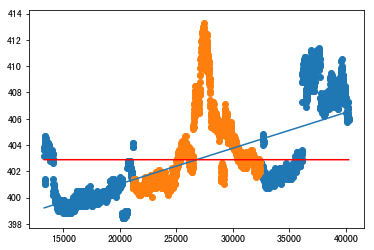

2019-01-24 18:33:17,787 <ipython-input-2-5bb95e59842f>[34] INFO blockid:6664, (2134, 2), (1524, 2), score=0.698


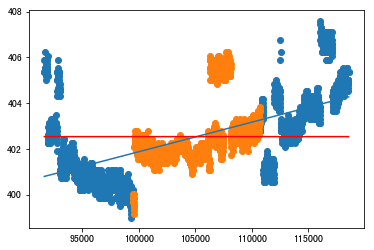

2019-01-24 18:33:17,913 <ipython-input-2-5bb95e59842f>[34] INFO blockid:6666, (2134, 2), (1524, 2), score=0.848


2019-01-24 18:33:18,050 <ipython-input-2-5bb95e59842f>[34] INFO blockid:6668, (2134, 2), (1524, 2), score=0.777


2019-01-24 18:33:18,187 <ipython-input-2-5bb95e59842f>[34] INFO blockid:6670, (2134, 2), (1524, 2), score=0.546


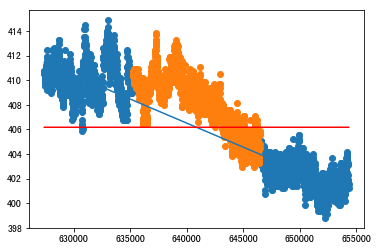

2019-01-24 18:33:18,405 <ipython-input-2-5bb95e59842f>[34] INFO blockid:6674, (2134, 2), (1524, 2), score=0.623


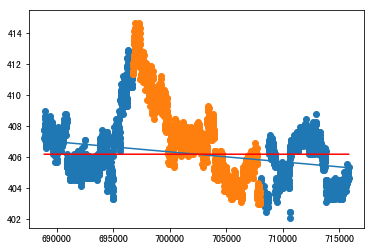

2019-01-24 18:33:18,533 <ipython-input-2-5bb95e59842f>[34] INFO blockid:6676, (2134, 2), (1524, 2), score=0.659


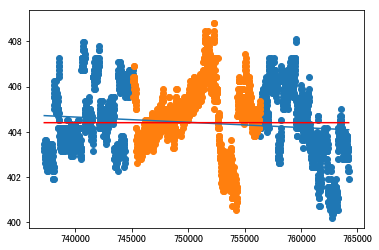

2019-01-24 18:33:18,665 <ipython-input-2-5bb95e59842f>[34] INFO blockid:6678, (2134, 2), (1524, 2), score=0.769


2019-01-24 18:33:18,813 <ipython-input-2-5bb95e59842f>[34] INFO blockid:6680, (2134, 2), (1524, 2), score=0.632


2019-01-24 18:33:18,937 <ipython-input-2-5bb95e59842f>[34] INFO blockid:6684, (2134, 2), (1524, 2), score=0.653


2019-01-24 18:33:19,057 <ipython-input-2-5bb95e59842f>[34] INFO blockid:6686, (1598, 2), (1524, 2), score=0.0


Total loss:0.6205, is_enum:False


In [2]:

logging.getLogger().setLevel(logging.INFO)
import matplotlib.pyplot as plt
col = 'var001'
train_list = get_train_feature(3, col)

train_list = sorted(train_list, key=lambda val: len(val[1]), reverse=True)

count, loss = 0, 0
for train, val, blockid in train_list[:10]:
    is_enum = True if 'int' in date_type[col].__name__ else False
    
#     if is_enum:
#         fn = lambda val:  np.full_like(val,train[col].value_counts().index[0])
#     else:    
#         w = np.polyfit (train.time_sn, train[col], 1)
#         fn = np.poly1d(w)
    fn = get_predict_fun(blockid,train)
    
    for color, data in zip(Category10[5][:2], [train, val]):
        plt.scatter(data.time_sn, data[col], c= color)
    
    x = np.linspace(train.time_sn.min(), train.time_sn.max(), 10000)
    
    
    cur_count, cur_loss = score(val[col], fn(val.time_sn), is_enum)
    
    loss  += cur_loss
    count += cur_count
    
    plt.plot(x, fn(x))    
    plt.plot(x, np.full_like(x, train[col].mean()) , c='r')  
    plt.show()
    logger.info(f'blockid:{blockid}, {train.shape}, {val.shape}, score={round(cur_loss/cur_count,3)}')
print(f'Total loss:{round(loss/count, 4)}, is_enum:{is_enum}')

## Predict submit data

/Users/lali2/Documents/workspace_py/df_jf/core/feature.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  template.drop(columns='sn', errors='ignore', inplace=True)
2019-01-24 18:33:25,618 <ipython-input-3-f4ae09650edf>[10] INFO blockid:1, train:(306, 2)


2019-01-24 18:33:25,800 <ipython-input-3-f4ae09650edf>[10] INFO blockid:3, train:(400, 2)


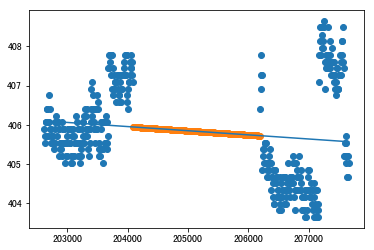

2019-01-24 18:33:25,958 <ipython-input-3-f4ae09650edf>[10] INFO blockid:5, train:(118, 2)


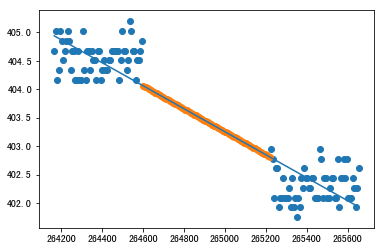

2019-01-24 18:33:26,124 <ipython-input-3-f4ae09650edf>[10] INFO blockid:7, train:(530, 2)


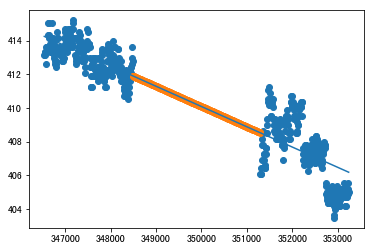

2019-01-24 18:33:26,286 <ipython-input-3-f4ae09650edf>[10] INFO blockid:9, train:(730, 2)


2019-01-24 18:33:26,446 <ipython-input-3-f4ae09650edf>[10] INFO blockid:11, train:(1958, 2)


2019-01-24 18:33:26,615 <ipython-input-3-f4ae09650edf>[10] INFO blockid:13, train:(1962, 2)


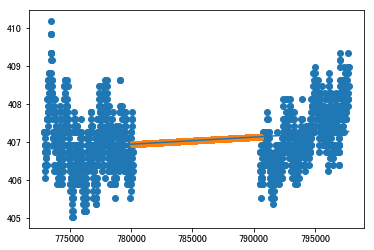

2019-01-24 18:33:26,794 <ipython-input-3-f4ae09650edf>[10] INFO blockid:15, train:(420, 2)


2019-01-24 18:33:26,951 <ipython-input-3-f4ae09650edf>[10] INFO blockid:17, train:(148, 2)


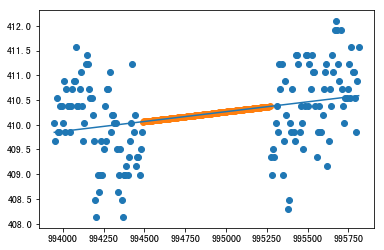

2019-01-24 18:33:27,112 <ipython-input-3-f4ae09650edf>[10] INFO blockid:19, train:(370, 2)


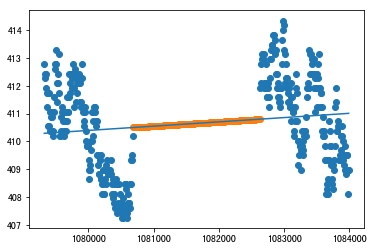

2019-01-24 18:33:27,273 <ipython-input-3-f4ae09650edf>[10] INFO blockid:21, train:(602, 2)


2019-01-24 18:33:27,455 <ipython-input-3-f4ae09650edf>[10] INFO blockid:23, train:(904, 2)


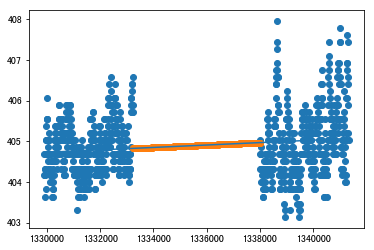

2019-01-24 18:33:27,630 <ipython-input-3-f4ae09650edf>[10] INFO blockid:25, train:(440, 2)


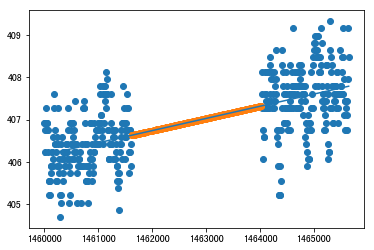

2019-01-24 18:33:27,809 <ipython-input-3-f4ae09650edf>[10] INFO blockid:27, train:(390, 2)


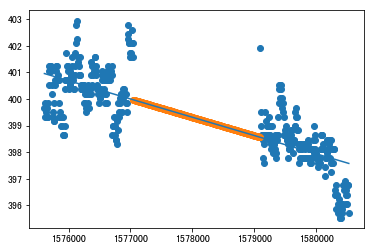

2019-01-24 18:33:27,982 <ipython-input-3-f4ae09650edf>[10] INFO blockid:29, train:(296, 2)


2019-01-24 18:33:28,147 <ipython-input-3-f4ae09650edf>[10] INFO blockid:31, train:(576, 2)


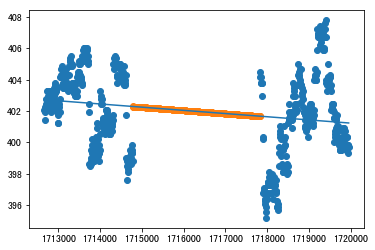

2019-01-24 18:33:28,329 <ipython-input-3-f4ae09650edf>[10] INFO blockid:33, train:(290, 2)


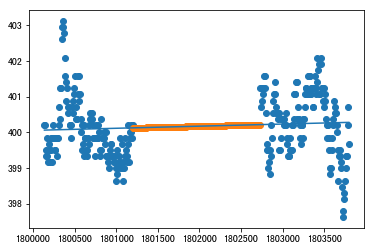

2019-01-24 18:33:28,510 <ipython-input-3-f4ae09650edf>[10] INFO blockid:35, train:(590, 2)


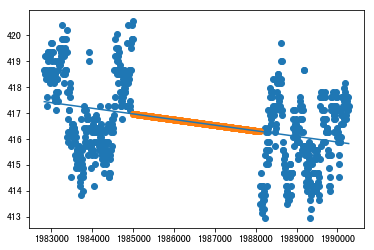

2019-01-24 18:33:28,724 <ipython-input-3-f4ae09650edf>[10] INFO blockid:37, train:(254, 2)


2019-01-24 18:33:28,913 <ipython-input-3-f4ae09650edf>[10] INFO blockid:39, train:(10, 2)


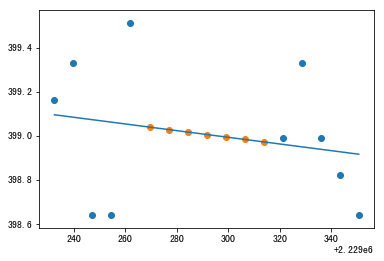

2019-01-24 18:33:29,093 <ipython-input-3-f4ae09650edf>[10] INFO blockid:41, train:(1492, 2)


2019-01-24 18:33:29,270 <ipython-input-3-f4ae09650edf>[10] INFO blockid:43, train:(488, 2)


2019-01-24 18:33:29,439 <ipython-input-3-f4ae09650edf>[10] INFO blockid:45, train:(2, 2)


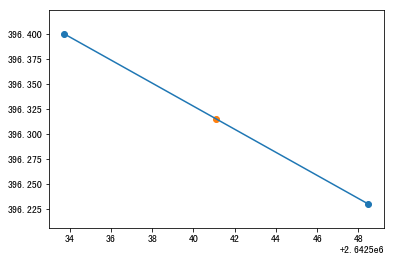

2019-01-24 18:33:29,615 <ipython-input-3-f4ae09650edf>[10] INFO blockid:47, train:(6, 2)


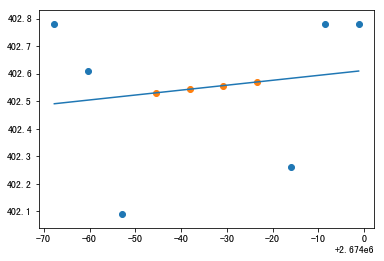

In [3]:


block = get_blocks() 
wtid = 1
col = 'var001'
missing_block = block.loc[(block.wtid == wtid) & (block.col == col) & (block.kind == 'missing')]
missing_block
for blockid, row in missing_block.iterrows():
    train, sub = get_submit_feature_by_block_id(blockid)
    logger.info(f'blockid:{blockid}, train:{train.shape}')
    predict_fn = get_predict_fun(blockid, train)
    predict_res = predict_fn(sub.time_sn)
    sub[col] = predict_res
    
    for color, data in zip(Category10[5][:2], [train, sub]):
        plt.scatter(data.time_sn, data[col], c= color)
    
    x = np.linspace(train.time_sn.min(), train.time_sn.max(), 10000)
    
    
    cur_count, cur_loss = score(sub[col], fn(sub.time_sn), is_enum)
    
    loss  += cur_loss
    count += cur_count
    
    plt.plot(x, predict_fn(x))    
#     plt.plot(x, np.full_like(x, train[col].mean()) , c='r')  
    plt.show()

In [3]:

# @file_cache()
# def get_std_all():
#     df = pd.DataFrame(columns=['wtid', 'col', 'mean', 'min', 'max', 'std'])
#     columns = list(date_type.keys())
#     columns.remove('wtid')
#     columns = sorted(columns)
#     for wtid in sorted(range(1, 34), reverse=True):
#         for col in columns:
#             std_sample =  check_std(wtid,col)
#             df = df.append(std_sample,ignore_index=True)          
#     return df
logging.getLogger().setLevel(logging.INFO)
std  = get_std_all()
std

2019-01-24 16:29:37,400 util_log.py[41] INFO get_std_all begin with(0 paras) :[], []
2019-01-24 16:29:37,434 util_log.py[49] INFO get_std_all cost    0.03 sec:(0 paras)([], []), return:DataFrame, end 


wtid     col     mean     min      max      std data_type
0      33  var001    2.324   1.086    4.464    0.829   float64
1      33  var002    2.044   0.301   10.107    2.751   float64
2      33  var003    4.400   0.511    9.908    2.615   float64
3      33  var004  183.756  35.570  345.762   96.610   float64
4      33  var005    2.334   1.101    4.464    0.816   float64
5      33  var006    0.341   0.073    0.659    0.165   float64
6      33  var007    0.388   0.091    0.911    0.200   float64
7      33  var008    0.117   0.000    0.339    0.101   float64
8      33  var009    0.013   0.007    0.029    0.006   float64
9      33  var010    0.011   0.010    0.012    0.001   float64
10     33  var011    0.341   0.073    0.659    0.165   float64
11     33  var012    0.872   0.278    2.186    0.503   float64
12     33  var013    0.003   0.000    0.005    0.002   float64
13     33  var014    0.388   0.091    0.911    0.200   float64
14     33  var015   20.802  11.496   77.670   14.547   float64
15     33  var016    0.846   0.000    4.058    1.207     int16
16     33  var017    0.019   0.009    0.039    0.006   float64
17     33  var018    0.250   0.080    0.464    0.106   float64
18     33  var019    7.165   0.000   28.044   10.514   float64
19     33  var020    0.000   0.000    0.000    0.000     int16
20     33  var021    1.259   0.274    4.461    1.195   float64
21     33  var022    0.344   0.104    0.788    0.180   float64
22     33  var023    0.014   0.010    0.029    0.004   float64
23     33  var024    4.316   0.515   10.034    2.580   float64
24     33  var025    0.118   0.000    0.348    0.103   float64
25     33  var026    0.118   0.000    0.347    0.102   float64
26     33  var027    1.272   0.796    2.494    0.420   float64
27     33  var028    0.940   0.361    3.514    0.710   float64
28     33  var029    0.344   0.104    0.788    0.180   float64
29     33  var030    1.348   0.278    5.093    1.358   float64
30     33  var031   11.573   3.264   70.089   14.899   float64
31     33  var032    0.003   0.000    0.007    0.001   float64
32     33  var033    1.443   0.319    4.405    1.026   float64
33     33  var034  216.238  34.120  390.513  116.617   float64
34     33  var035    3.853   0.519    8.565    2.228   float64
35     33  var036    1.199   0.359    2.675    0.618   float64
36     33  var037    0.291   0.089    0.710    0.147   float64
37     33  var038    2.155   1.001    4.111    0.731   float64
38     33  var039    0.008   0.004    0.014    0.003   float64
39     33  var040    4.115   0.548    9.334    2.416   float64
40     33  var041    0.047   0.016    0.095    0.020   float64
41     33  var042  183.406  37.311  343.977   95.554   float64
42     33  var043  209.994  31.537  393.596  116.674   float64
43     33  var044    0.015   0.010    0.019    0.002   float64
44     33  var045    4.601   0.568   10.352    2.729   float64
45     33  var046  184.588  36.846  345.636   96.051   float64
46     33  var047    0.000   0.000    0.000    0.000     int16
47     33  var048    0.009   0.004    0.016    0.003   float64
48     33  var049    0.007   0.004    0.013    0.002   float64
49     33  var050    0.012   0.000    0.037    0.013   float64
50     33  var051    0.465   0.067    1.452    0.353   float64
51     33  var052    4.551   0.579   10.406    2.705   float64
52     33  var053    0.173   0.000    0.500    0.205     int16
53     33  var054    1.917   1.739    2.881    0.242   float64
54     33  var055    1.085   0.086    5.474    1.474   float64
55     33  var056   27.659   3.319  165.912   36.969   float64
56     33  var057    0.442   0.063    1.224    0.300   float64
57     33  var058    0.007   0.005    0.015    0.003   float64
58     33  var059    7.172   0.000   28.006   10.502   float64
59     33  var060    0.024   0.023    0.025    0.001   float64
60     33  var061   13.854   5.300   73.513   15.251   float64
61     33  var062    0.246   0.073    0.512    0.106   float64
62     33  var063    0.011   0.004  

In [38]:
tmp = std.groupby(['col', 'data_type'])['mean'].mean().sort_values().to_frame().reset_index()
print(tmp.columns)
tmp[tmp['data_type']=='int16']

Index(['col', 'data_type', 'mean'], dtype='object')


col data_type      mean
2   var066     int16  0.006545
5   var047     int16  0.007667
16  var053     int16  0.139576
36  var016     int16  0.889091
44  var020     int16  1.758152

In [ ]:
columns = list(date_type.keys())
columns.remove('wtid')
columns = sorted(columns)
for wtid in sorted(range(1, 34), reverse=True):
    for col in columns:
        check_std(wtid,col)

In [4]:
logging.getLogger().setLevel(logging.DEBUG)


get_sub_template()

ts  wtid        sn  var001  var002  var003  var004  var005  var006  var007  var008  var009  var010  var011  var012  var013  var014  var015  var016  var017  var018  var019  var020  var021  var022  var023  var024  var025  var026  var027  var028  var029  var030  var031  var032  var033  var034  var035  var036  var037  var038  var039  var040  var041  var042  var043  var044  var045  var046  var047  var048  var049  var050  var051  var052  var053  var054  var055  var056  var057  var058  var059  var060  var061  var062  var063  var064  var065  var066  var067  var068
5119    2018-07-01 10:12:44.963     1    4986.0  410.37   27.89   41.09  348.79  409.85   32.29   32.50     0.0   59.04   -0.30   32.29   27.75     NaN   32.50     NaN     NaN   59.12   34.70   -0.66     NaN   27.89   32.20    0.00   42.00     0.0     0.0     NaN   24.54   32.20   27.60     NaN     NaN   37.20     NaN   40.50   30.60   34.50  408.65    0.03   42.09     NaN  347.60     NaN   29.58   43.00  356.39     NaN   29.61     NaN    1.00   30.00   43.79     NaN     NaN   30.10     NaN   30.00     NaN   -0.50   49.95     NaN   34.79   59.15   29.54   -0.62     NaN   26.89     NaN
5121    2018-07-01 10:12:52.365     1    4987.0  410.37   27.89   41.29  354.00  409.85   32.29   32.50     0.0   59.04   -0.30   32.29   27.64     NaN   32.50     NaN     NaN   59.12   34.70   -0.66     NaN   27.89   32.09    0.04   41.79     0.0     0.0     NaN   24.54   32.09   27.60     NaN     NaN   37.20     NaN   40.50   30.60   34.50  408.99    0.01   41.70     NaN  354.79     NaN   29.58   43.09  360.39     NaN   29.60     NaN    1.00   30.00   43.50     NaN     NaN   30.10     NaN   30.00     NaN   -0.50   49.95     NaN   34.79   59.16   29.54   -0.62     NaN   26.89     NaN
5123    2018-07-01 10:12:59.731     1    4988.0  409.68   27.89   40.40  411.20  410.20   32.29   32.50     0.0   59.04   -0.30   32.29   27.75     NaN   32.50     NaN     NaN   59.14   34.70   -0.66     NaN   27.89   32.20    0.02   42.00     0.0     0.0     NaN   24.54   32.20   27.50     NaN     NaN   37.29     NaN   40.40   30.60   34.50  408.82    0.03   42.09     NaN  407.60     NaN   29.56   43.00  416.39     NaN   29.61     NaN    1.00   30.00   44.00     NaN     NaN   30.10     NaN   30.00     NaN   -0.50   49.95     NaN   34.79   59.15   29.54   -0.62     NaN   26.89     NaN
5125    2018-07-01 10:13:07.118     1    4989.0  410.54   27.89   40.50  471.20  410.72   32.29   32.50     0.0   59.05   -0.31   32.29   27.64     NaN   32.50     NaN     NaN   59.12   34.59   -0.66     NaN   27.89   32.20    0.00   42.00     0.0     0.0     NaN   24.54   32.20   27.60     NaN     NaN   37.29     NaN   40.29   30.60   34.50  409.17    0.01   41.90     NaN  470.79     NaN   29.58   42.90  478.79     NaN   29.62     NaN    1.00   30.00   43.50     NaN     NaN   30.10     NaN   30.00     NaN   -0.50   49.97     NaN   34.79   59.16   29.54   -0.62     NaN   26.89     NaN
5127    2018-07-01 10:13:14.506     1    4990.0  410.89   27.89   40.50  438.00  410.72   32.29   32.50     0.0   59.04   -0.30   32.29   27.64     NaN   32.50     NaN     NaN   59.13   34.70   -0.66     NaN   27.89   32.20    0.03   42.00     0.0     0.0     NaN   24.54   32.20   27.60     NaN     NaN   37.20     NaN   40.50   30.60   34.50  409.51    0.02   41.50     NaN  440.00     NaN   29.59   43.00  445.60     NaN   29.60     NaN    1.00   30.00   44.00     NaN     NaN   30.10     NaN   30.00     NaN   -0.50   49.95     NaN   34.79   59.15   29.54   -0.62     NaN   26.89     NaN
5129    2018-07-01 10:13:21.870     1    4991.0  410.54   27.89   40.50  392.39  410.89   32.29   32.50     0.0   59.04   -0.30   32.29   27.64     NaN   32.50     NaN     NaN   59.13   34.70   -0.66     NaN   27.89   32.20    0.02   41.90     0.0     0.0     NaN   24.54   32.20   27.60     NaN     NaN   37.29     NaN   40.50   30.60   34.50  409.34    0.03   41.29     NaN  393.20     NaN   29.60   43.00  398.00     NaN   29.60     NaN    1.00   30.00   43.90     NaN     N

In [55]:
get_blocks().iloc[45]

begin         354983
col           var001
distinct         NaN
end           354983
kind         missing
max              NaN
min              NaN
wtid               1
length             1
data_type    float64
Name: 45, dtype: object

In [41]:
get_blocks().iloc[6735]

begin         157660
col           var002
distinct          62
end           173119
kind           train
max               36
min             29.7
wtid               3
length         15460
data_type    float64
Name: 6735, dtype: object

In [48]:

tmp = get_train_ex(3).loc[173119-4000:173119][['time_sn', 'var002']]
tmp.loc[(tmp.time_sn > 1250000) & (tmp.time_sn < 1290000)]

time_sn  var002
171484  1250005.605   30.10
171485  1250012.971   30.10
171486  1250020.339   30.10
171487  1250027.705   30.10
171488  1250035.068   30.10
171489  1250042.437   30.10
171490  1250049.801   30.10
171491  1250057.167   30.10
171492  1250064.533   30.10
171493  1250071.902   30.10
171494  1250079.264   30.10
171495  1250086.631   30.10
171496  1250093.997   30.10
171497  1250101.363   30.10
171498  1250108.728   30.00
171499  1250116.095   30.10
171500  1250123.464   30.10
171501  1250130.827   30.10
171502  1250138.192   30.10
171503  1250145.558   30.10
171504  1250152.931   30.10
171505  1250160.290   30.00
171506  1250167.659   30.10
171507  1250175.022   30.10
171508  1250182.390   30.10
171509  1250189.754   30.00
171510  1250197.121   30.10
171511  1250204.487   30.10
171512  1250211.851   30.10
171513  1250219.219   30.10
171514  1250226.584   30.10
171515  1250233.950   30.10
171516  1250241.316   30.00
171517  1250248.681   30.10
171518  1250256.053   30.10
171519  1250263.414   30.10
171520  1250270.780   30.10
171521  1250278.146   30.10
171522  1250285.513   30.10
171523  1250292.877   30.00
171524  1250300.244   30.00
171525  1250307.614   30.10
171526  1250314.977   30.10
171527  1250322.342   30.10
171528  1250329.710   30.00
171529  1250337.076   30.10
171530  1250344.439   30.00
171531  1250351.806   30.00
171532  1250359.171   30.10
171533  1250366.537   30.00
171534  1250373.903   30.00
171535  1250381.269   30.00
171536  1250388.636   30.10
171537  1250396.002   30.00
171538  1250403.367   30.10
171539  1250410.732   30.00
171540  1250418.103   30.10
171541  1250425.470   30.00
171542  1250432.831   30.00
171543  1250440.200   30.00
171544  1250447.566   30.10
171545  1250454.931   30.00
171546  1250462.295   30.00
171547  1250469.661   30.00
171548  1250477.030   30.00
171549  1250484.393   30.00
171550  1250491.759   30.00
171551  1250499.125   30.00
171552  1250506.494   30.00
171553  1250513.856   30.00
171554  1250521.222   30.00
171555  1250528.589   30.00
171556  1250535.956   30.00
171557  1250543.320   30.00
171558  1250550.687   30.00
171559  1250558.054   30.00
171560  1250565.424   30.00
171561  1250572.785   30.00
171562  1250580.152   30.00
171563  1250587.516   30.00
171564  1250594.883   30.00
171565  1250602.248   30.00
171566  1250609.621   30.00
171567  1250616.980   30.00
171568  1250624.346   30.00
171569  1250631.712   30.00
171570  1250639.079   30.00
171571  1250646.443   30.00
171572  1250653.810   30.00
171573  1250661.182   30.00
171574  1250668.542   30.00
171575  1250675.908   30.00
171576  1250683.274   30.00
171577  1250690.644   30.00
171578  1250698.006   30.00
171579  1250705.375   30.00
171580  1250712.737   30.00
171581  1250720.104   30.00
171582  1250727.470   30.00
171583  1250734.836   30.00
171584  1250742.203   30.00
171585  1250749.567   30.00
171586  1250756.933   30.00
171587  1250764.302   30.00
171588  1250771.666   30.00
171589  1250779.031   30.00
171590  1250786.397   30.00
171591  1250793.770   30.00
171592  1250801.132   30.00
171593  1250808.495   30.00
171594  1250815.862   30.00
171595  1250823.227   30.00
171596  1250830.594   30.00
171597  1250837.964   30.00
171598  1250845.325   30.00
171599  1250852.693   30.00
171600  1250860.057   30.00
171601  1250867.543   30.00
171602  1250874.908   30.00
171603  1250882.275   30.00
171604  1250889.640   30.00
171605  1250897.007   30.00
171606  1250904.375   30.00
171607  1250911.739   30.00
171608  1250919.104   30.00
171609  1250926.471   30.00
171610  1250933.836   30.00
171611  1250941.202   30.00
171612  1250948.569   30.00
171613  1250955.934   30.00
171614  1250963.300   30.00
171615  1250970.667   30.00
171616  1250978.032   30.00
171617  1250985.398   30.00
171618  1250992.764   30.00
171619  1251000.130   30.00
171620  1251007.537   30.00
171621  1251014.908   30.00
171622  1251022.268   30.00
171623  1251029.638   30.00
171624  1251037.001   30.00
171625  1251044.369   30.00
171626  

In [ ]:


feature_list = get_train_feature(1, 'var001')

len(feature_list)

In [ ]:
bk.groupby(['wtid','col']).length.sum()

In [ ]:


def get_missing_block_all():
    """
    wtid, col, begin, end
    :return:
    """
    df = pd.DataFrame(columns=['wtid', 'col', 'begin', 'end'])
    columns = list(date_type.keys())
    columns.remove('wtid')
    columns = sorted(columns)
    for wtid in sorted(range(1, 34), reverse=True):
        for col in columns:
            for begin, end in get_result(wtid, col) :
                df = df.append({'wtid':wtid, 'col':col, 'begin':begin, 'end':end}, ignore_index=True)
    return df

get_missing_block_all()

In [ ]:
 
        
col = 'var003'
get_result(1, col)


In [ ]:
train = get_train_ex(1)
train.iloc[354983-3: 354983+3]

In [ ]:

print(__doc__)

# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#
# License: BSD 3 clause

import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel


rng = np.random.RandomState(0)
X = rng.uniform(0, 5, 20)[:, np.newaxis]
y = 0.5 * np.sin(3 * X[:, 0]) + rng.normal(0, 0.5, X.shape[0])

# First run
plt.figure(0)
kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X, y)
X_ = np.linspace(0, 5, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
plt.plot(X_, 0.5*np.sin(3*X_), 'r', lw=3, zorder=9)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

# Second run
plt.figure(1)
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X, y)
X_ = np.linspace(0, 5, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
plt.plot(X_, 0.5*np.sin(3*X_), 'r', lw=3, zorder=9)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

# Plot LML landscape
plt.figure(2)
theta0 = np.logspace(-2, 3, 49)
theta1 = np.logspace(-2, 0, 50)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = [[gp.log_marginal_likelihood(np.log([0.36, Theta0[i, j], Theta1[i, j]]))
        for i in range(Theta0.shape[0])] for j in range(Theta0.shape[1])]
LML = np.array(LML).T

vmin, vmax = (-LML).min(), (-LML).max()
vmax = 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)
plt.contour(Theta0, Theta1, -LML,
            levels=level, norm=LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.tight_layout()

plt.show()


In [ ]:
tmp['time_sn'] = (tmp.ts - pd.to_datetime('2018-07-01')).astype(int)/1000000000
 
# from datetime import timedelta
# tmp['gap'] = tmp['gap']/timedelta(hours=1)
# #tmp['gap'] = (  pd.to_datetime(tmp.ts2) - pd.to_datetime(tmp.ts) ) #/ np.timedelta64(1, 's')
# tmp.head()
#tmp.gap.astype(int)
tmp

In [ ]:
train = get_train_ex(1) 



missing = train[pd.isna(train['var001'])].index


In [ ]:
tmp.iloc[170590: 170599]

In [ ]:
tmp_1.var001.iloc[200:300].plot()
plot.show()

In [ ]:
tmp_1.var001.dropna().plot()
plot.show()

In [ ]:
len(tmp_1.var003), len(tmp_1.var003.dropna())

In [ ]:
from core.config import date_type
example = pd.read_csv('./input/submit_example.csv', dtype=date_type) 
example.head()


example.var016.drop_duplicates()


In [ ]:
pd.value_counts(example.var016)

In [ ]:
example.var001.iloc[0:3].astype(str)

In [ ]:
example.var001.iloc[0:3].apply(lambda val : True if val==405.37 else False)

In [ ]:
example.head()

In [ ]:
plt.show()

In [ ]:
from core import feature

In [ ]:

template = pd.read_csv('./input/template_submit_result.csv') 

print(template.shape)
#template 

In [ ]:

template = pd.read_csv('./input/template_submit_result.csv') 

train = pd.read_csv('./input/001/201807.csv') 
print(train.shape)

template = template.set_index(['ts', 'wtid'])
train = train.set_index(['ts', 'wtid'])


train = train[train.index.isin(template.index)]

train.shape

tmp = template.combine_first(train)
print(tmp.shape)


In [ ]:

 

tmp = get_sub_template()

tmp.head()

In [ ]:
tmp = get_sub_template()


In [ ]:
tmp.head(100)

In [ ]:
train_01 = pd.read_csv('./input/001/201807.csv') 
train_01.head()
#del train_01




In [ ]:
from core.feature import *
df = get_missing_analysis()

In [ ]:
df

In [ ]:
df.describe()

In [ ]:
df.var001[:1].describe()

In [ ]:
df.var001.astype(int).std()

In [ ]:
np.finfo(np.float16).max

In [ ]:

def get_analysis_enum():
    col_list = ['wtid','var053','var066','var016','var020','var047',  ]

    train_list = []
    for wtid in range(1, 34):
        wtid = str(wtid)
        train = pd.read_csv(f"./input/{wtid.rjust(3,'0')}/201807.csv", usecols=col_list)
        train = train.groupby(col_list).agg({'wtid':'count'})
        train.rename(index=str, columns={"wtid": "count"}, inplace=True)
        train = train.reset_index()
        print(train.shape)
        train_list.append(train)

    all = pd.concat(train_list)
    return all

enum_type = get_analysis_enum()

In [ ]:
tmp = enum_type[['var053','var066','var016','var020','var047',]].drop_duplicates(['var053','var066','var016','var020','var047',])

In [ ]:
enum_type.sort_values(['wtid', 'count', ], ascending=False)

In [ ]:
for i in sorted((range(1, 34)),reverse=True):
    print(i)

In [29]:
import pprint
pprint.pprint(abc)

pprint.PrettyPrinter?

{'a': 'b', 'c': 'd'}


In [27]:
abc = {'a':'b', 'c':'d'}


{'a': 'b', 'c': 'd'}


In [30]:
tmp = get_blocks()

In [31]:
tmp.drop(index=)

begin     col  distinct     end     kind      max     min wtid length data_type
0            0  var001      99.0    9546    train   415.89  398.99    1   9547   float64
1         9547  var001       NaN    9764  missing      NaN     NaN    1    218   float64
2         9765  var001      95.0   27673    train   415.89  399.68    1  17909   float64
3        27674  var001       NaN   27958  missing      NaN     NaN    1    285   float64
4        27959  var001      45.0   35878    train   409.17  400.54    1   7920   float64
5        35879  var001       NaN   35963  missing      NaN     NaN    1     85   float64
6        35964  var001      81.0   47256    train    415.2  401.23    1  11293   float64
7        47257  var001       NaN   47635  missing      NaN     NaN    1    379   float64
8        47636  var001      92.0   70205    train   415.72  399.51    1  22570   float64
9        70206  var001       NaN   70726  missing      NaN     NaN    1    521   float64
10       70727  var001      46.0   73291    train   413.65  405.54    1   2565   float64
11       73292  var001       NaN   74690  missing      NaN     NaN    1   1399   float64
12       74691  var001     103.0  105776    train    417.1  399.33    1  31086   float64
13      105777  var001       NaN  107178  missing      NaN     NaN    1   1402   float64
14      107179  var001      90.0  127671    train   418.65  402.44    1  20493   float64
15      127672  var001       NaN  127971  missing      NaN     NaN    1    300   float64
16      127972  var001      83.0  134843    train   419.51   405.2    1   6872   float64
17      134844  var001       NaN  134949  missing      NaN     NaN    1    106   float64
18      134950  var001      68.0  146531    train   413.48  401.92    1  11582   float64
19      146532  var001       NaN  146795  missing      NaN     NaN    1    264   float64
20      146796  var001      75.0  159592    train   414.34  401.23    1  12797   float64
21      159593  var001       NaN  160022  missing      NaN     NaN    1    430   float64
22      160023  var001      90.0  177478    train   412.96       0    1  17456   float64
23      177479  var001       NaN  178124  missing      NaN     NaN    1    646   float64
24      178125  var001      57.0  194889    train   411.92  401.92    1  16765   float64
25      194890  var001       NaN  195204  missing      NaN     NaN    1    315   float64
26      195205  var001      99.0  210530    train    413.3  396.05    1  15326   float64
27      210531  var001       NaN  210808  missing      NaN     NaN    1    278   float64
28      210809  var001      62.0  214559    train   402.09  391.57    1   3751   float64
29      214560  var001       NaN  214770  missing      NaN     NaN    1    211   float64
30      214771  var001     113.0  229043    train   410.72  391.23    1  14273   float64
31      229044  var001       NaN  229455  missing      NaN     NaN    1    412   float64
32      229456  var001      99.0  240762    train   409.85  392.95    1  11307   float64
33      240763  var001       NaN  240969  missing      NaN     NaN    1    207   float64
34      240970  var001     175.0  265689    train   423.48  392.95    1  24720   float64
35      265690  var001       NaN  266110  missing      NaN     NaN    1    421   float64
36      266111  var001     181.0  285819    train   423.66  392.43    1  19709   float64
37      285820  var001       NaN  286000  missing      NaN     NaN    1    181   float64
38      286001  var001      86.0  298810    train   404.68  388.29    1  12810   float64
39      298811  var001       NaN  298817  missing      NaN     NaN    1      7   float64
40      298818  var001     136.0  302842    train   417.96  394.16    1   4025   float64
41      302843  var001       NaN  303908  missing      NaN     NaN    1   1066   float64
42      303909  var001     119.0  334601    train   407.79  387.43    1  30693   float64
43      334602  var001       NaN  334950  missing      NaN     NaN    1    349   float64
44  